# 📊 Subtask Execution Results Analysis Dashboard

## 🎯 Overview
This comprehensive analysis notebook provides detailed insights into subtask execution performance with beautiful visualizations and multi-dimensional analysis.

## 🚀 Features:
- **📈 Overall Performance Metrics**: Completion rates, exeution statistics, and key performance indicators
- 
- **📋 Task Category Analysis**: Performance breakdown by task types (direct_command, attribute_reasoning, tool_use, etc.)
- **🤖 Agent Type Analysis**: Single-agent vs multi-agent performance comparison
- **🔍 Multi-Dimensional Analysis**: Cross-tabulation and correlation analysis
- **⚠️ Bad Case Analysis**: Detailed failure pattern analysis
- **🎨 Beautiful Visualizations**: Light color scheme with professional styling
- **💡 Intelligent Insights**: AI-generated recommendations and actionable insights

## 📦 Required Libraries
Run the following command if any libraries are missing:
```bash
pip install pandas numpy matplotlib seaborn plotly jupyter
```

In [46]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for beautiful visualizations with light color scheme
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['grid.color'] = '#E5E5E5'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['text.color'] = '#333333'
plt.rcParams['axes.labelcolor'] = '#333333'
plt.rcParams['xtick.color'] = '#666666'
plt.rcParams['ytick.color'] = '#666666'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Define beautiful light color palettes
LIGHT_COLORS = {
    'primary': ['#E8F4FD', '#B3E0FF', '#7CC7FF', '#4DAAFF', '#1A8CFF', '#0066CC'],
    'success': ['#E8F5E8', '#C8E6C9', '#A5D6A7', '#81C784', '#66BB6A', '#4CAF50'],
    'warning': ['#FFF8E1', '#FFECB3', '#FFE082', '#FFD54F', '#FFCA28', '#FFC107'],
    'error': ['#FFEBEE', '#FFCDD2', '#EF9A9A', '#E57373', '#EF5350', '#F44336'],
    'info': ['#E3F2FD', '#BBDEFB', '#90CAF9', '#64B5F6', '#42A5F5', '#2196F3'],
    'purple': ['#F3E5F5', '#E1BEE7', '#CE93D8', '#BA68C8', '#AB47BC', '#9C27B0'],
    'teal': ['#E0F2F1', '#B2DFDB', '#80CBC4', '#4DB6AC', '#26A69A', '#009688'],
    'orange': ['#FFF3E0', '#FFE0B2', '#FFCC80', '#FFB74D', '#FFA726', '#FF9800']
}

# Set seaborn style with light theme
sns.set_style("whitegrid", {
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
    "grid.linewidth": 0.5,
    "grid.color": "#E5E5E5"
})

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Libraries imported successfully!")
print("🎨 Beautiful light color scheme configured!")

✅ Libraries imported successfully!
🎨 Beautiful light color scheme configured!


## 📁 Data Loading and Preprocessing

In [47]:
def find_latest_log_file(output_dir='../output', custom_csv_path=None):
    """
    Find the latest subtask_execution_log.csv file or use manual/custom path
    
    Args:
        output_dir: Directory to search for log files
        manual_path: Manual path to specific log file (deprecated, use custom_csv_path)
        custom_csv_path: Custom path to any CSV file (supports any CSV file, not just subtask_execution_log.csv)
    
    Returns:
        str: Path to the log file
    """
    # Priority: custom_csv_path > manual_path > auto-detection
    
    # Check custom CSV path first (highest priority)
    if custom_csv_path:
        if os.path.exists(custom_csv_path):
            if custom_csv_path.endswith('.csv'):
                print(f"📁 Using custom CSV path: {custom_csv_path}")
                return custom_csv_path
            else:
                print(f"⚠️  Warning: Custom path '{custom_csv_path}' is not a CSV file, but proceeding...")
                return custom_csv_path
        else:
            print(f"❌ Custom CSV path does not exist: {custom_csv_path}")
            print(f"🔍 Falling back to auto-detection...")
    
    # Auto-detection: Find all subtask_execution_log.csv files
    pattern = os.path.join(output_dir, '**/subtask_execution_log.csv')
    log_files = glob.glob(pattern, recursive=True)
    
    if not log_files:
        raise FileNotFoundError(f"❌ No subtask_execution_log.csv files found in {output_dir}")
    
    # Sort by modification time and get the latest
    latest_file = max(log_files, key=os.path.getmtime)
    print(f"📁 Using latest log file: {latest_file}")
    return latest_file

def validate_data_for_plotting(df):
    """
    Validate data and report potential issues that could cause empty plots
    """
    print("\n🔍 DATA VALIDATION FOR PLOTTING")
    print("-" * 40)
    
    # Check for required columns
    required_cols = ['task_category', 'subtask_completed', 'total_steps', 'duration_seconds', 'command_success_rate_numeric']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"⚠️ Missing columns: {missing_cols}")
    
    # Check data distribution
    print(f"📊 Data shape: {df.shape}")
    print(f"📋 Task categories: {list(df['task_category'].unique())}")
    print(f"✅ Completed tasks: {df['subtask_completed'].sum()}/{len(df)} ({df['subtask_completed'].mean()*100:.1f}%)")
    
    # Check for empty categories
    category_counts = df['task_category'].value_counts()
    print(f"📈 Tasks per category:")
    for cat, count in category_counts.items():
        success_rate = df[df['task_category']==cat]['subtask_completed'].mean() * 100
        print(f"  - {cat}: {count} tasks ({success_rate:.1f}% success)")
    
    # Check for NaN values
    nan_cols = df.isnull().sum()
    nan_cols = nan_cols[nan_cols > 0]
    if len(nan_cols) > 0:
        print(f"⚠️ Columns with NaN values: {dict(nan_cols)}")
    
    return True

def safe_numeric_conversion(series, default_value=0):
    """
    Safely convert a series to numeric, handling NaN and missing values
    """
    try:
        return pd.to_numeric(series, errors='coerce').fillna(default_value)
    except Exception:
        return pd.Series([default_value] * len(series), index=series.index)

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the subtask execution log data
    
    Args:
        file_path: Path to the CSV file
    
    Returns:
        pd.DataFrame: Preprocessed data
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Convert timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # Convert boolean columns
    df['task_executed'] = df['task_executed'].astype(bool)
    df['subtask_completed'] = df['subtask_completed'].astype(bool)
    
    # Convert command_success_rate from percentage string to float
    # First ensure the column is string type and handle NaN values
    df['command_success_rate'] = df['command_success_rate'].astype(str)
    df['command_success_rate_numeric'] = df['command_success_rate'].str.rstrip('%').astype(float)
    
    # Extract scenario number from scenario_id (handle missing values)
    # First ensure the column is string type
    df['scenario_id'] = df['scenario_id'].astype(str)
    scenario_numbers = df['scenario_id'].str.extract(r'(\\d+)')
    df['scenario_number'] = pd.to_numeric(scenario_numbers[0], errors='coerce').fillna(0).astype(int)
    
    # Add derived columns
    df['failure_rate'] = 100 - df['command_success_rate_numeric']
    df['steps_per_second'] = df['total_steps'] / df['duration_seconds']
    df['efficiency_score'] = (df['command_success_rate_numeric'] * df['subtask_completed'].astype(int)) / (df['total_steps'] + 1)
    
    print(f"📊 Loaded {len(df)} records from {file_path}")
    print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"📋 Task categories: {', '.join(df['task_category'].unique())}")
    print(f"🤖 Agent types: {', '.join(df['agent_type'].unique())}")
    
    return df

# Load data - You can specify a custom CSV file path
# 注意：请先运行评测任务生成数据文件，或者将路径修改为实际存在的CSV文件
custom_csv_path =   "../output/20250706_164540_single_parallel_independent_scenario_multi_demo/subtask_execution_log.csv"
# custom_csv_path = "/Users/wangzixuan/workspace/sim/embodied_framework/output/20250704_164535_single_parallel_independent_scenario_multi_demo/subtask_execution_log.csv"  # 示例绝对路径
# Examples of usage:
# custom_csv_path = '../output/specific_folder/subtask_execution_log.csv'  # Specific subtask log
# custom_csv_path = '../output/my_custom_results.csv'  # Any custom CSV file
# custom_csv_path = '/absolute/path/to/your/data.csv'  # Absolute path

log_file_path = find_latest_log_file(custom_csv_path=custom_csv_path)
df = load_and_preprocess_data(log_file_path)

# Display basic info about the dataset
print("\n" + "="*60)
print("📋 DATASET OVERVIEW")
print("="*60)
print(df.info())
print("\n📊 First few rows:")
display(df.head())

📁 Using custom CSV path: ../output/20250706_164540_single_parallel_independent_scenario_multi_demo/subtask_execution_log.csv
📊 Loaded 48 records from ../output/20250706_164540_single_parallel_independent_scenario_multi_demo/subtask_execution_log.csv
📅 Date range: 2025-07-06 16:46:12.519406 to 2025-07-06 16:53:08.457058
📋 Task categories: direct_command, attribute_reasoning, tool_use, compound_reasoning
🤖 Agent types: single_agent

📋 DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     48 non-null     datetime64[ns]
 1   scenario_id                   48 non-null     object        
 2   subtask_index                 48 non-null     int64         
 3   subtask_description           48 non-null     object        
 4   task_category                 48 non-null 

,timestamp,scenario_id,subtask_index,subtask_description,task_category,agent_type,status,task_executed,subtask_completed,total_steps,successful_steps,failed_steps,command_success_rate,start_time,end_time,duration_seconds,llm_interactions,command_success_rate_numeric,scenario_number,failure_rate,steps_per_second,efficiency_score
0,2025-07-06 16:46:12.519406,00004_subtask_000,1,Place the calibration tablet with id 'calibrat...,direct_command,single_agent,failed,False,False,20,2,18,10.00%,2025-07-06 16:45:41.171661,2025-07-06 16:46:12.519375,31.35,20,10.0,0,90.0,0.637959,0.0
1,2025-07-06 16:46:13.319079,00006_subtask_000,1,Place the thermal_scanner_1 on the collaborati...,direct_command,single_agent,failed,False,False,20,1,19,5.00%,2025-07-06 16:45:41.153122,2025-07-06 16:46:13.319043,32.17,20,5.0,0,95.0,0.621697,0.0
2,2025-07-06 16:46:16.541456,00005_subtask_000,1,Place the laser_pointer_1 on the holographic_c...,direct_command,single_agent,failed,False,False,20,1,19,5.00%,2025-07-06 16:45:41.176951,2025-07-06 16:46:16.541423,35.36,20,5.0,0,95.0,0.565611,0.0
3,2025-07-06 16:46:19.052454,00001_subtask_000,1,Place the oscilloscope probe set with id 'osci...,direct_command,single_agent,failed,False,False,20,0,20,0.00%,2025-07-06 16:45:41.156970,2025-07-06 16:46:19.052419,37.90,20,0.0,0,100.0,0.527704,0.0
4,2025-07-06 16:46:20.868432,00003_subtask_000,1,Place the u87_microphone_1 on the producers_de...,direct_command,single_agent,failed,False,False,20,2,18,10.00%,2025-07-06 16:45:41.165438,2025-07-06 16:46:20.868386,39.70,20,10.0,0,90.0,0.503778,0.0


## 📈 Overall Performance Analysis


📊 OVERALL PERFORMANCE METRICS
📈 Total Tasks Analyzed: 48
✅ Tasks Executed: 0 (0.0%)
✅ Successfully Completed: 2 (4.2%)
❌ Failed Tasks: 46 (95.8%)
⏱️  Average Duration: 35.0 seconds
🔢 Average Steps per Task: 20.0
🎯 Average Command Success Rate: 15.7%
🤖 Average LLM Interactions: 20.0

📊 TASK SUCCESS RATE BY CATEGORY (KEY METRICS)
------------------------------------------------------------
                     Total_Tasks  Successful_Tasks  Failed_Tasks  Success_Rate_Percent
task_category                                                                         
attribute_reasoning           14                 1            13                   7.1
compound_reasoning            10                 0            10                   0.0
direct_command                14                 1            13                   7.1
tool_use                      10                 0            10                   0.0

👣 AVERAGE STEPS BY TASK CATEGORY
----------------------------------------
           

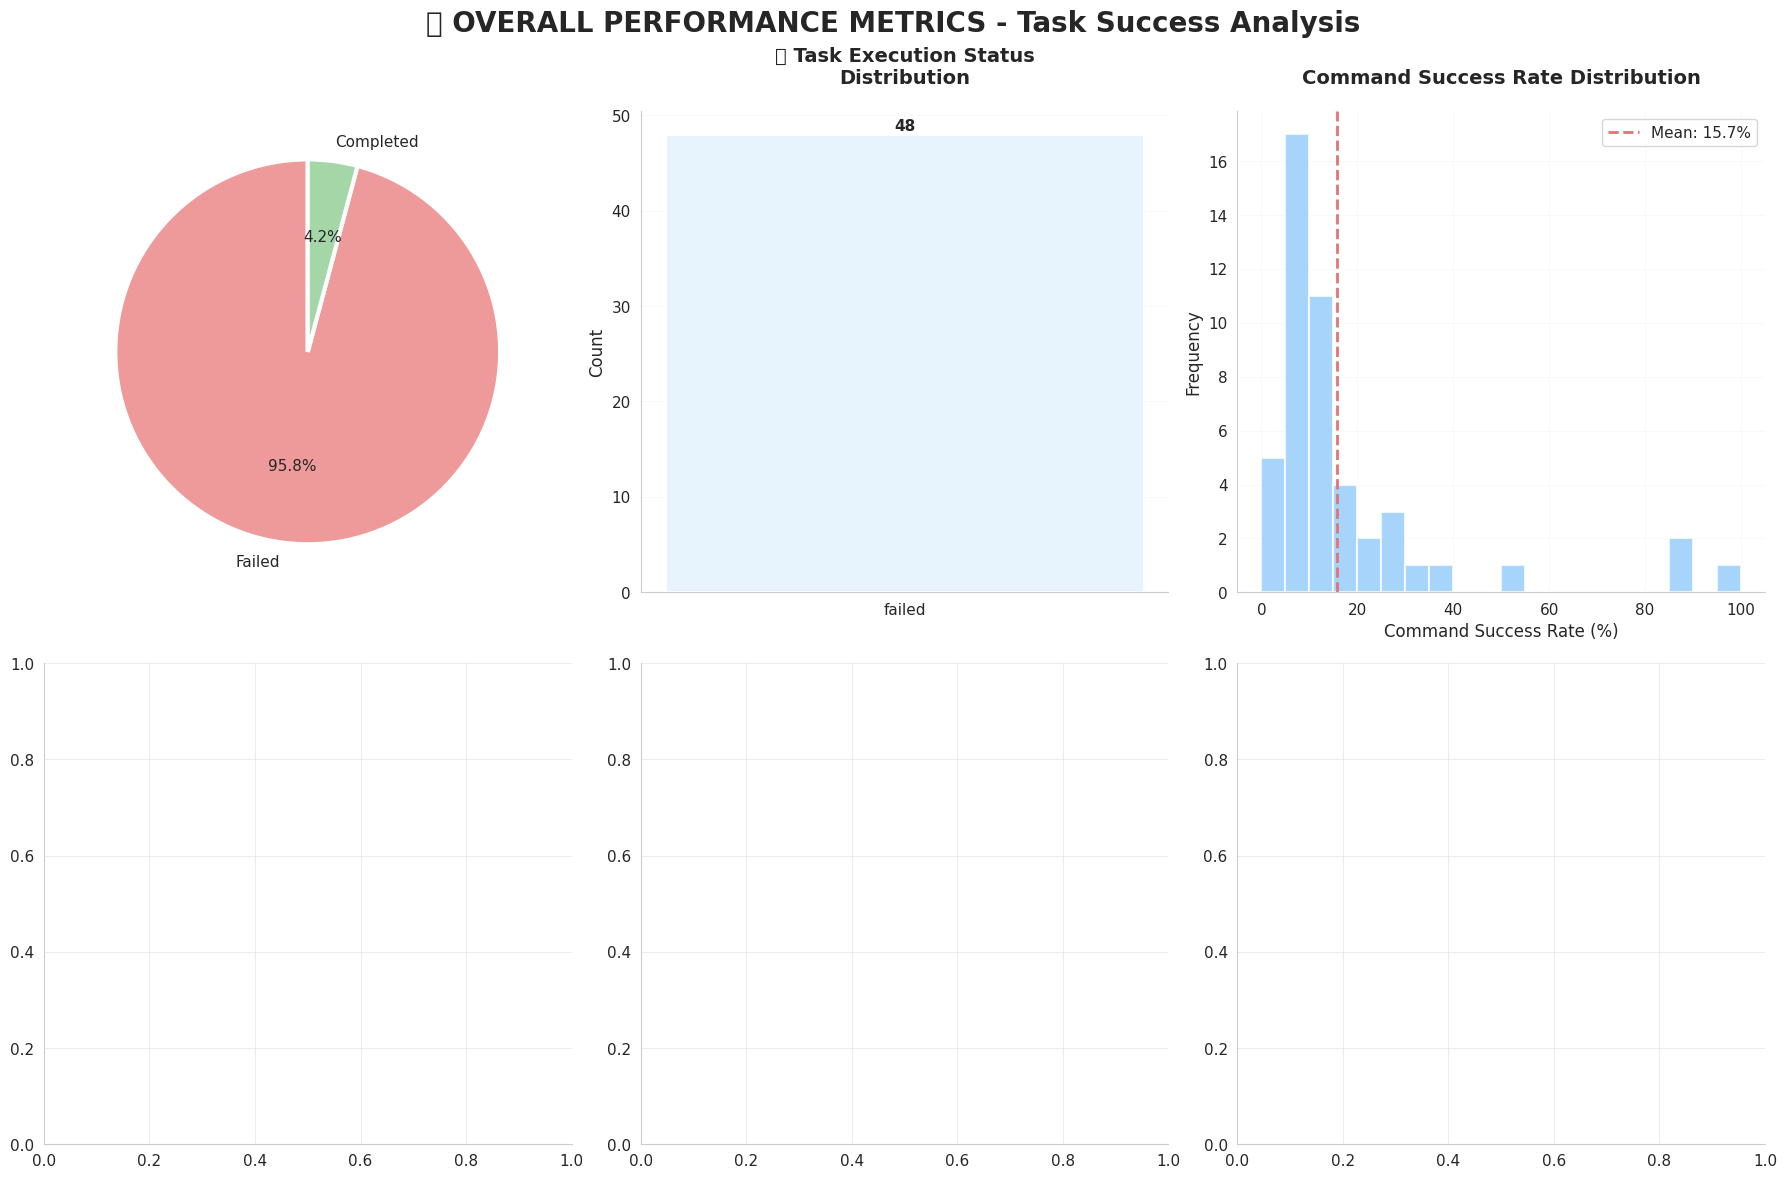

In [48]:
def analyze_overall_performance(df):
    """
    Analyze overall performance metrics with beautiful visualizations
    """
    print("\n" + "="*60)
    print("📊 OVERALL PERFORMANCE METRICS")
    print("="*60)
    
    total_tasks = len(df)
    completed_tasks = df['subtask_completed'].sum()
    executed_tasks = df['task_executed'].sum()
    completion_rate = (completed_tasks / total_tasks) * 100
    execution_rate = (executed_tasks / total_tasks) * 100
    
    print(f"📈 Total Tasks Analyzed: {total_tasks}")
    print(f"✅ Tasks Executed: {executed_tasks} ({execution_rate:.1f}%)")
    print(f"✅ Successfully Completed: {completed_tasks} ({completion_rate:.1f}%)")
    print(f"❌ Failed Tasks: {total_tasks - completed_tasks} ({100 - completion_rate:.1f}%)")
    print(f"⏱️  Average Duration: {df['duration_seconds'].mean():.1f} seconds")
    print(f"🔢 Average Steps per Task: {df['total_steps'].mean():.1f}")
    print(f"🎯 Average Command Success Rate: {df['command_success_rate_numeric'].mean():.1f}%")
    print(f"🤖 Average LLM Interactions: {df['llm_interactions'].mean():.1f}")
    
    # Task Success Rate by Category (Most Important Analysis)
    print(f"\n📊 TASK SUCCESS RATE BY CATEGORY (KEY METRICS)")
    print("-" * 60)
    category_success = df.groupby('task_category')['subtask_completed'].agg(['count', 'sum', 'mean']).round(3)
    category_success.columns = ['Total_Tasks', 'Successful_Tasks', 'Success_Rate']
    category_success['Success_Rate_Percent'] = (category_success['Success_Rate'] * 100).round(1)
    category_success['Failed_Tasks'] = category_success['Total_Tasks'] - category_success['Successful_Tasks']
    
    # Reorder columns for better readability
    category_success = category_success[['Total_Tasks', 'Successful_Tasks', 'Failed_Tasks', 'Success_Rate_Percent']]
    print(category_success.to_string())
    
    # Average Steps by Category (Second Most Important)
    print(f"\n👣 AVERAGE STEPS BY TASK CATEGORY")
    print("-" * 40)
    steps_by_category = df.groupby('task_category')['total_steps'].agg(['mean', 'std', 'min', 'max']).round(1)
    steps_by_category.columns = ['Avg_Steps', 'Std_Steps', 'Min_Steps', 'Max_Steps']
    print(steps_by_category.to_string())
    
    # Validate data before plotting
    validate_data_for_plotting(df)
    
    # Create beautiful overview dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.patch.set_facecolor('white')
    fig.suptitle('📊 OVERALL PERFORMANCE METRICS - Task Success Analysis', fontsize=20, fontweight='bold', y=0.98)
    
    # # 1. Completion Rate Pie Chart
    # ax1 = axes[0, 0]
    # completion_counts = df['subtask_completed'].value_counts()
    # colors = [LIGHT_COLORS['error'][2], LIGHT_COLORS['success'][2]]
    # wedges, texts, autotexts = ax1.pie(completion_counts.values, labels=['Failed', 'Completed'], 
    #                                   autopct='%1.1f%%', colors=colors, startangle=90,
    #                                   wedgeprops=dict(edgecolor='white', linewidth=3))
    # ax1.set_title('🎯 Task Success Rate\n(Most Important Metric)', fontweight='bold', pad=20, fontsize=14)
    # for autotext in autotexts:
    #     autotext.set_color('white')
    #     autotext.set_fontweight('bold')
    #     autotext.set_fontsize(12)
    
    # 1. Completion Rate Pie Chart
    ax1 = axes[0, 0]
    completion_counts = df['subtask_completed'].value_counts()

    # 动态创建标签和数据，确保顺序一致
    values = []
    labels = []
    colors = []

    # 按照 value_counts 的实际顺序添加数据
    for status in completion_counts.index:
        values.append(completion_counts[status])
        if status == False:
            labels.append('Failed')
            colors.append(LIGHT_COLORS['error'][2])
        else:  # status == True
            labels.append('Completed')
            colors.append(LIGHT_COLORS['success'][2])

    wedges, texts, autotexts = ax1.pie(values, labels=labels, 
                                    autopct='%1.1f%%', colors=colors, startangle=90,
                                    wedgeprops=dict(edgecolor='white', linewidth=3))
    
    # 2. Execution Status Distribution
    ax2 = axes[0, 1]
    status_counts = df['status'].value_counts()
    colors2 = LIGHT_COLORS['primary'][:len(status_counts)]
    bars2 = ax2.bar(status_counts.index, status_counts.values, color=colors2, 
                    edgecolor='white', linewidth=2)
    ax2.set_title('📋 Task Execution Status\nDistribution', fontweight='bold', pad=20, fontsize=14)
    ax2.set_ylabel('Count')
    ax2.grid(True, alpha=0.3)
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Command Success Rate Distribution
    ax3 = axes[0, 2]
    ax3.hist(df['command_success_rate_numeric'], bins=20, color=LIGHT_COLORS['info'][2], 
             alpha=0.8, edgecolor='white', linewidth=1.5)
    ax3.axvline(df['command_success_rate_numeric'].mean(), color=LIGHT_COLORS['error'][3], 
                linestyle='--', linewidth=2, label=f'Mean: {df["command_success_rate_numeric"].mean():.1f}%')
    ax3.set_title('Command Success Rate Distribution', fontweight='bold', pad=20)
    ax3.set_xlabel('Command Success Rate (%)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    return fig

# Generate overall performance analysis
overall_fig = analyze_overall_performance(df)
plt.tight_layout()
plt.show()

## 📋 Task Category Analysis

📋 TASK CATEGORY PERFORMANCE ANALYSIS
--------------------------------------------------
📊 Category Summary:
                     Total_Tasks  Completed_Tasks  Completion_Rate  Avg_Steps  \
task_category                                                                   
attribute_reasoning           14                1              7.1       20.0   
compound_reasoning            10                0              0.0       20.0   
direct_command                14                1              7.1       20.0   
tool_use                      10                0              0.0       20.0   

                     Avg_Duration  Avg_Command_Success  
task_category                                           
attribute_reasoning        33.126                8.214  
compound_reasoning         36.099                9.500  
direct_command             35.310               18.929  
tool_use                   36.039               28.000  

🏆 最佳类别 (成功率): attribute_reasoning (7.1%)
❌ 最差类别 (成功率): compoun

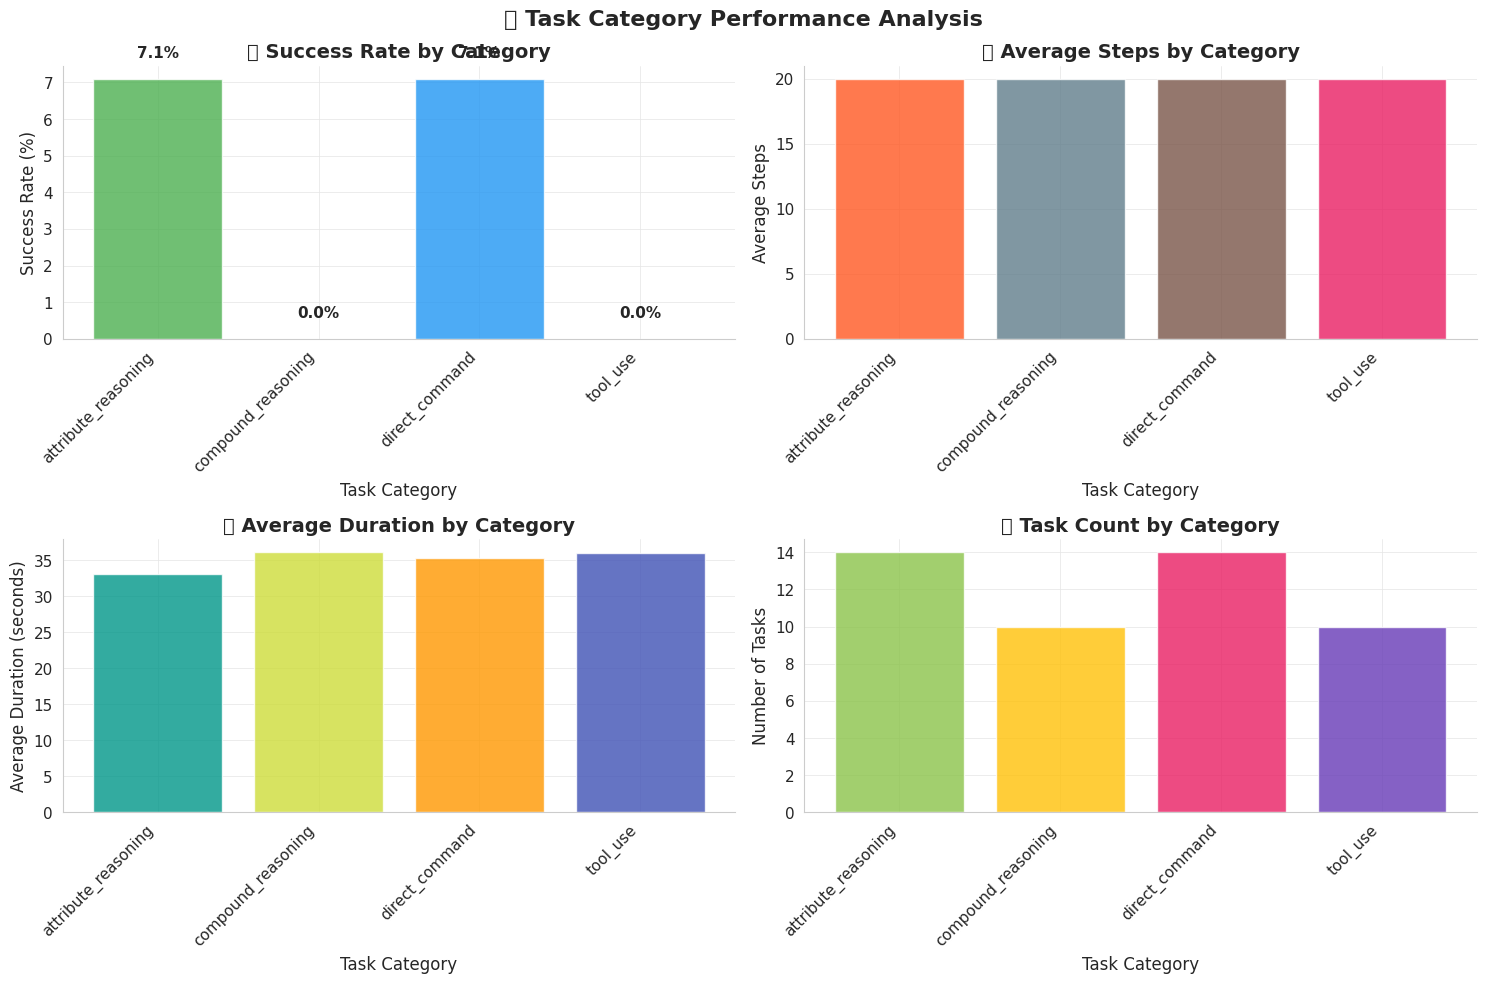

In [49]:
# def analyze_task_categories(df):
#     """
#     Analyze performance by task category with beautiful visualizations
#     """
#     print("\n" + "="*60)
#     print("📋 TASK CATEGORY ANALYSIS")
#     print("="*60)
    
#     category_stats = df.groupby('task_category').agg({
#         'subtask_completed': ['count', 'sum', 'mean'],
#         'total_steps': ['mean', 'std'],
#         'duration_seconds': ['mean', 'std'],
#         'command_success_rate_numeric': ['mean', 'std'],
#         'llm_interactions': ['mean', 'std']
#     }).round(2)
    
#     category_stats.columns = ['_'.join(col).strip() for col in category_stats.columns]
#     category_summary = category_stats[['subtask_completed_count', 'subtask_completed_sum', 'subtask_completed_mean',
#                                       'total_steps_mean', 'duration_seconds_mean', 'command_success_rate_numeric_mean']]
#     category_summary.columns = ['Total_Tasks', 'Completed_Tasks', 'Completion_Rate', 
#                                'Avg_Steps', 'Avg_Duration', 'Avg_Command_Success']
#     category_summary['Completion_Rate'] = (category_summary['Completion_Rate'] * 100).round(1)
    
#     print(category_summary)
    
#     best_category = category_summary['Completion_Rate'].idxmax()
#     worst_category = category_summary['Completion_Rate'].idxmin()
#     fastest_category = category_summary['Avg_Duration'].idxmin()
#     slowest_category = category_summary['Avg_Duration'].idxmax()
    
#     print(f"\n🏆 Best Performing Category: {best_category} ({category_summary.loc[best_category, 'Completion_Rate']:.1f}% completion)")
#     print(f"⚠️  Worst Performing Category: {worst_category} ({category_summary.loc[worst_category, 'Completion_Rate']:.1f}% completion)")
#     print(f"⚡ Fastest Category: {fastest_category} ({category_summary.loc[fastest_category, 'Avg_Duration']:.1f}s avg)")
#     print(f"🐌 Slowest Category: {slowest_category} ({category_summary.loc[slowest_category, 'Avg_Duration']:.1f}s avg)")
    
#     # Create comprehensive category analysis dashboard
#     fig, axes = plt.subplots(2, 3, figsize=(20, 14))
#     fig.patch.set_facecolor('white')
#     fig.suptitle('📋 Task Category Performance Analysis', fontsize=20, fontweight='bold', y=0.98)
    
#     categories = category_summary.index
#     n_categories = len(categories)
#     colors = LIGHT_COLORS['primary'][:n_categories] if n_categories <= 6 else sns.color_palette("husl", n_categories)
    
#     # 1. Task Distribution by Category
#     ax1 = axes[0, 0]
#     category_counts = df['task_category'].value_counts()
#     wedges, texts, autotexts = ax1.pie(category_counts.values, labels=category_counts.index, 
#                                       autopct='%1.1f%%', colors=colors, startangle=90,
#                                       wedgeprops=dict(edgecolor='white', linewidth=2))
#     ax1.set_title('Task Distribution by Category', fontweight='bold', pad=20)
#     for autotext in autotexts:
#         autotext.set_color('white')
#         autotext.set_fontweight('bold')
    
#     # 2. Completion Rate by Category
#     ax2 = axes[0, 1]
#     bars2 = ax2.bar(categories, category_summary['Completion_Rate'], color=colors,
#                     edgecolor='white', linewidth=2)
#     ax2.set_title('🎯 Task Success Rate by Category\n(Key Performance Indicator)', fontweight='bold', pad=20, fontsize=14)
#     ax2.set_ylabel('Completion Rate (%)')
#     ax2.set_ylim(0, 105)
#     ax2.grid(True, alpha=0.3)
#     ax2.tick_params(axis='x', rotation=45)
#     for bar in bars2:
#         height = bar.get_height()
#         ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
#                  f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
#     # 3. Average Steps by Category
#     ax3 = axes[0, 2]
#     bars3 = ax3.bar(categories, category_summary['Avg_Steps'], color=LIGHT_COLORS['info'][:n_categories],
#                     edgecolor='white', linewidth=2)
#     ax3.set_title('👣 Average Steps by Category\n(Efficiency Metric)', fontweight='bold', pad=20, fontsize=14)
#     ax3.set_ylabel('Average Steps')
#     ax3.grid(True, alpha=0.3)
#     ax3.tick_params(axis='x', rotation=45)
#     for bar in bars3:
#         height = bar.get_height()
#         ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
#                  f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
#     # 4. Duration Distribution by Category (Box Plot)
#     ax4 = axes[1, 0]
#     sns.boxplot(data=df, x='task_category', y='duration_seconds', ax=ax4, palette=colors)
#     ax4.set_title('Duration Distribution by Category', fontweight='bold', pad=20)
#     ax4.set_xlabel('Task Category')
#     ax4.set_ylabel('Duration (seconds)')
#     ax4.tick_params(axis='x', rotation=45)
#     ax4.grid(True, alpha=0.3)
    
#     # 5. Command Success Rate by Category (Violin Plot)
#     ax5 = axes[1, 1]
#     sns.violinplot(data=df, x='task_category', y='command_success_rate_numeric', ax=ax5, palette=colors)
#     ax5.set_title('Command Success Rate Distribution', fontweight='bold', pad=20)
#     ax5.set_xlabel('Task Category')
#     ax5.set_ylabel('Command Success Rate (%)')
#     ax5.tick_params(axis='x', rotation=45)
#     ax5.grid(True, alpha=0.3)
    
#     # 6. Steps vs Success Rate Scatter
#     ax6 = axes[1, 2]
#     for i, category in enumerate(categories):
#         cat_data = df[df['task_category'] == category]
#         ax6.scatter(cat_data['total_steps'], cat_data['command_success_rate_numeric'], 
#                    color=colors[i], label=category, alpha=0.7, s=60, edgecolors='white', linewidth=1)
#     ax6.set_title('Steps vs Command Success Rate', fontweight='bold', pad=20)
#     ax6.set_xlabel('Total Steps')
#     ax6.set_ylabel('Command Success Rate (%)')
#     ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     ax6.grid(True, alpha=0.3)
    
#     return fig, category_summary

def analyze_task_categories(df):
    """
    修复后的任务类别分析函数
    """
    print("📋 TASK CATEGORY PERFORMANCE ANALYSIS")
    print("-" * 50)
    
    # 确保数据类型正确
    df['subtask_completed'] = df['subtask_completed'].astype(bool)
    
    # 按任务类别分组并计算统计信息
    try:
        category_stats = df.groupby('task_category').agg({
            'subtask_completed': ['count', 'sum', 'mean'],
            'total_steps': 'mean',
            'duration_seconds': 'mean',
            'command_success_rate': lambda x: pd.to_numeric(x.astype(str).str.rstrip('%'), errors='coerce').mean()
        }).round(3)
        
        # 正确处理多级列索引
        # 展平列名
        new_columns = []
        for col in category_stats.columns:
            if isinstance(col, tuple):
                if col[1] == '<lambda>':
                    new_columns.append(f'{col[0]}_lambda')
                else:
                    new_columns.append(f'{col[0]}_{col[1]}')
            else:
                new_columns.append(col)
        
        category_stats.columns = new_columns
        
        # 创建新的DataFrame，确保列名正确
        final_stats = pd.DataFrame({
            'Total_Tasks': category_stats['subtask_completed_count'],
            'Completed_Tasks': category_stats['subtask_completed_sum'],
            'Completion_Rate': (category_stats['subtask_completed_mean'] * 100).round(1),
            'Avg_Steps': category_stats['total_steps_mean'],
            'Avg_Duration': category_stats['duration_seconds_mean'],
            'Avg_Command_Success': category_stats['command_success_rate_lambda']
        })
        
        print("📊 Category Summary:")
        print(final_stats)
        print()
        
        # 检查是否有数据
        if len(final_stats) == 0:
            print('❌ 没有数据可分析')
            return None, None
        
        # 安全地找到最佳/最差类别
        if not final_stats['Completion_Rate'].empty and len(final_stats) > 0:
            best_category = final_stats['Completion_Rate'].idxmax()
            worst_category = final_stats['Completion_Rate'].idxmin()
            fastest_category = final_stats['Avg_Duration'].idxmin()
            
            print(f'🏆 最佳类别 (成功率): {best_category} ({final_stats.loc[best_category, "Completion_Rate"]}%)')
            print(f'❌ 最差类别 (成功率): {worst_category} ({final_stats.loc[worst_category, "Completion_Rate"]}%)')
            print(f'⚡ 最快类别 (持续时间): {fastest_category} ({final_stats.loc[fastest_category, "Avg_Duration"]:.1f}s)')
        else:
            print('⚠️ 无法计算最佳/最差类别')
        
        # 创建可视化（简化版本）
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('📋 Task Category Performance Analysis', fontsize=16, fontweight='bold')
        
        # 1. 成功率柱状图
        ax1 = axes[0, 0]
        bars = ax1.bar(final_stats.index, final_stats['Completion_Rate'], 
                       color=['#4CAF50', '#FF9800', '#2196F3', '#9C27B0'], alpha=0.8)
        ax1.set_title('🎯 Success Rate by Category', fontweight='bold')
        ax1.set_ylabel('Success Rate (%)')
        ax1.set_xlabel('Task Category')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        # 添加数值标签
        for bar, value in zip(bars, final_stats['Completion_Rate']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{value}%', ha='center', va='bottom', fontweight='bold')
        
        # 2. 平均步数
        ax2 = axes[0, 1]
        ax2.bar(final_stats.index, final_stats['Avg_Steps'], 
                color=['#FF5722', '#607D8B', '#795548', '#E91E63'], alpha=0.8)
        ax2.set_title('👣 Average Steps by Category', fontweight='bold')
        ax2.set_ylabel('Average Steps')
        ax2.set_xlabel('Task Category')
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        
        # 3. 平均持续时间
        ax3 = axes[1, 0]
        ax3.bar(final_stats.index, final_stats['Avg_Duration'], 
                color=['#009688', '#CDDC39', '#FF9800', '#3F51B5'], alpha=0.8)
        ax3.set_title('⏱️ Average Duration by Category', fontweight='bold')
        ax3.set_ylabel('Average Duration (seconds)')
        ax3.set_xlabel('Task Category')
        plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
        
        # 4. 任务数量分布
        ax4 = axes[1, 1]
        ax4.bar(final_stats.index, final_stats['Total_Tasks'], 
                color=['#8BC34A', '#FFC107', '#E91E63', '#673AB7'], alpha=0.8)
        ax4.set_title('📊 Task Count by Category', fontweight='bold')
        ax4.set_ylabel('Number of Tasks')
        ax4.set_xlabel('Task Category')
        plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        
        return fig, final_stats
        
    except Exception as e:
        print(f'❌ 分析过程中出错: {e}')
        import traceback
        traceback.print_exc()
        return None, None
# Generate task category analysis
category_fig, category_summary = analyze_task_categories(df)
plt.tight_layout()
plt.show()

## 📊 Detailed Category-wise Statistics


📊 DETAILED CATEGORY-WISE STATISTICAL ANALYSIS

📋 1. COMPREHENSIVE STATISTICS BY TASK CATEGORY
------------------------------------------------------------
                     Total_Tasks  Completed  Completion_Rate_%  Avg_Steps  Avg_Duration_s  Avg_Cmd_Success_%  Avg_LLM_Interactions  Efficiency_Score
task_category                                                                                                                                       
attribute_reasoning           14          1                7.0       20.0           33.13               8.21                  20.0              0.02
compound_reasoning            10          0                0.0       20.0           36.10               9.50                  20.0              0.00
direct_command                14          1                7.0       20.0           35.31              18.93                  20.0              0.02
tool_use                      10          0                0.0       20.0           36.04          

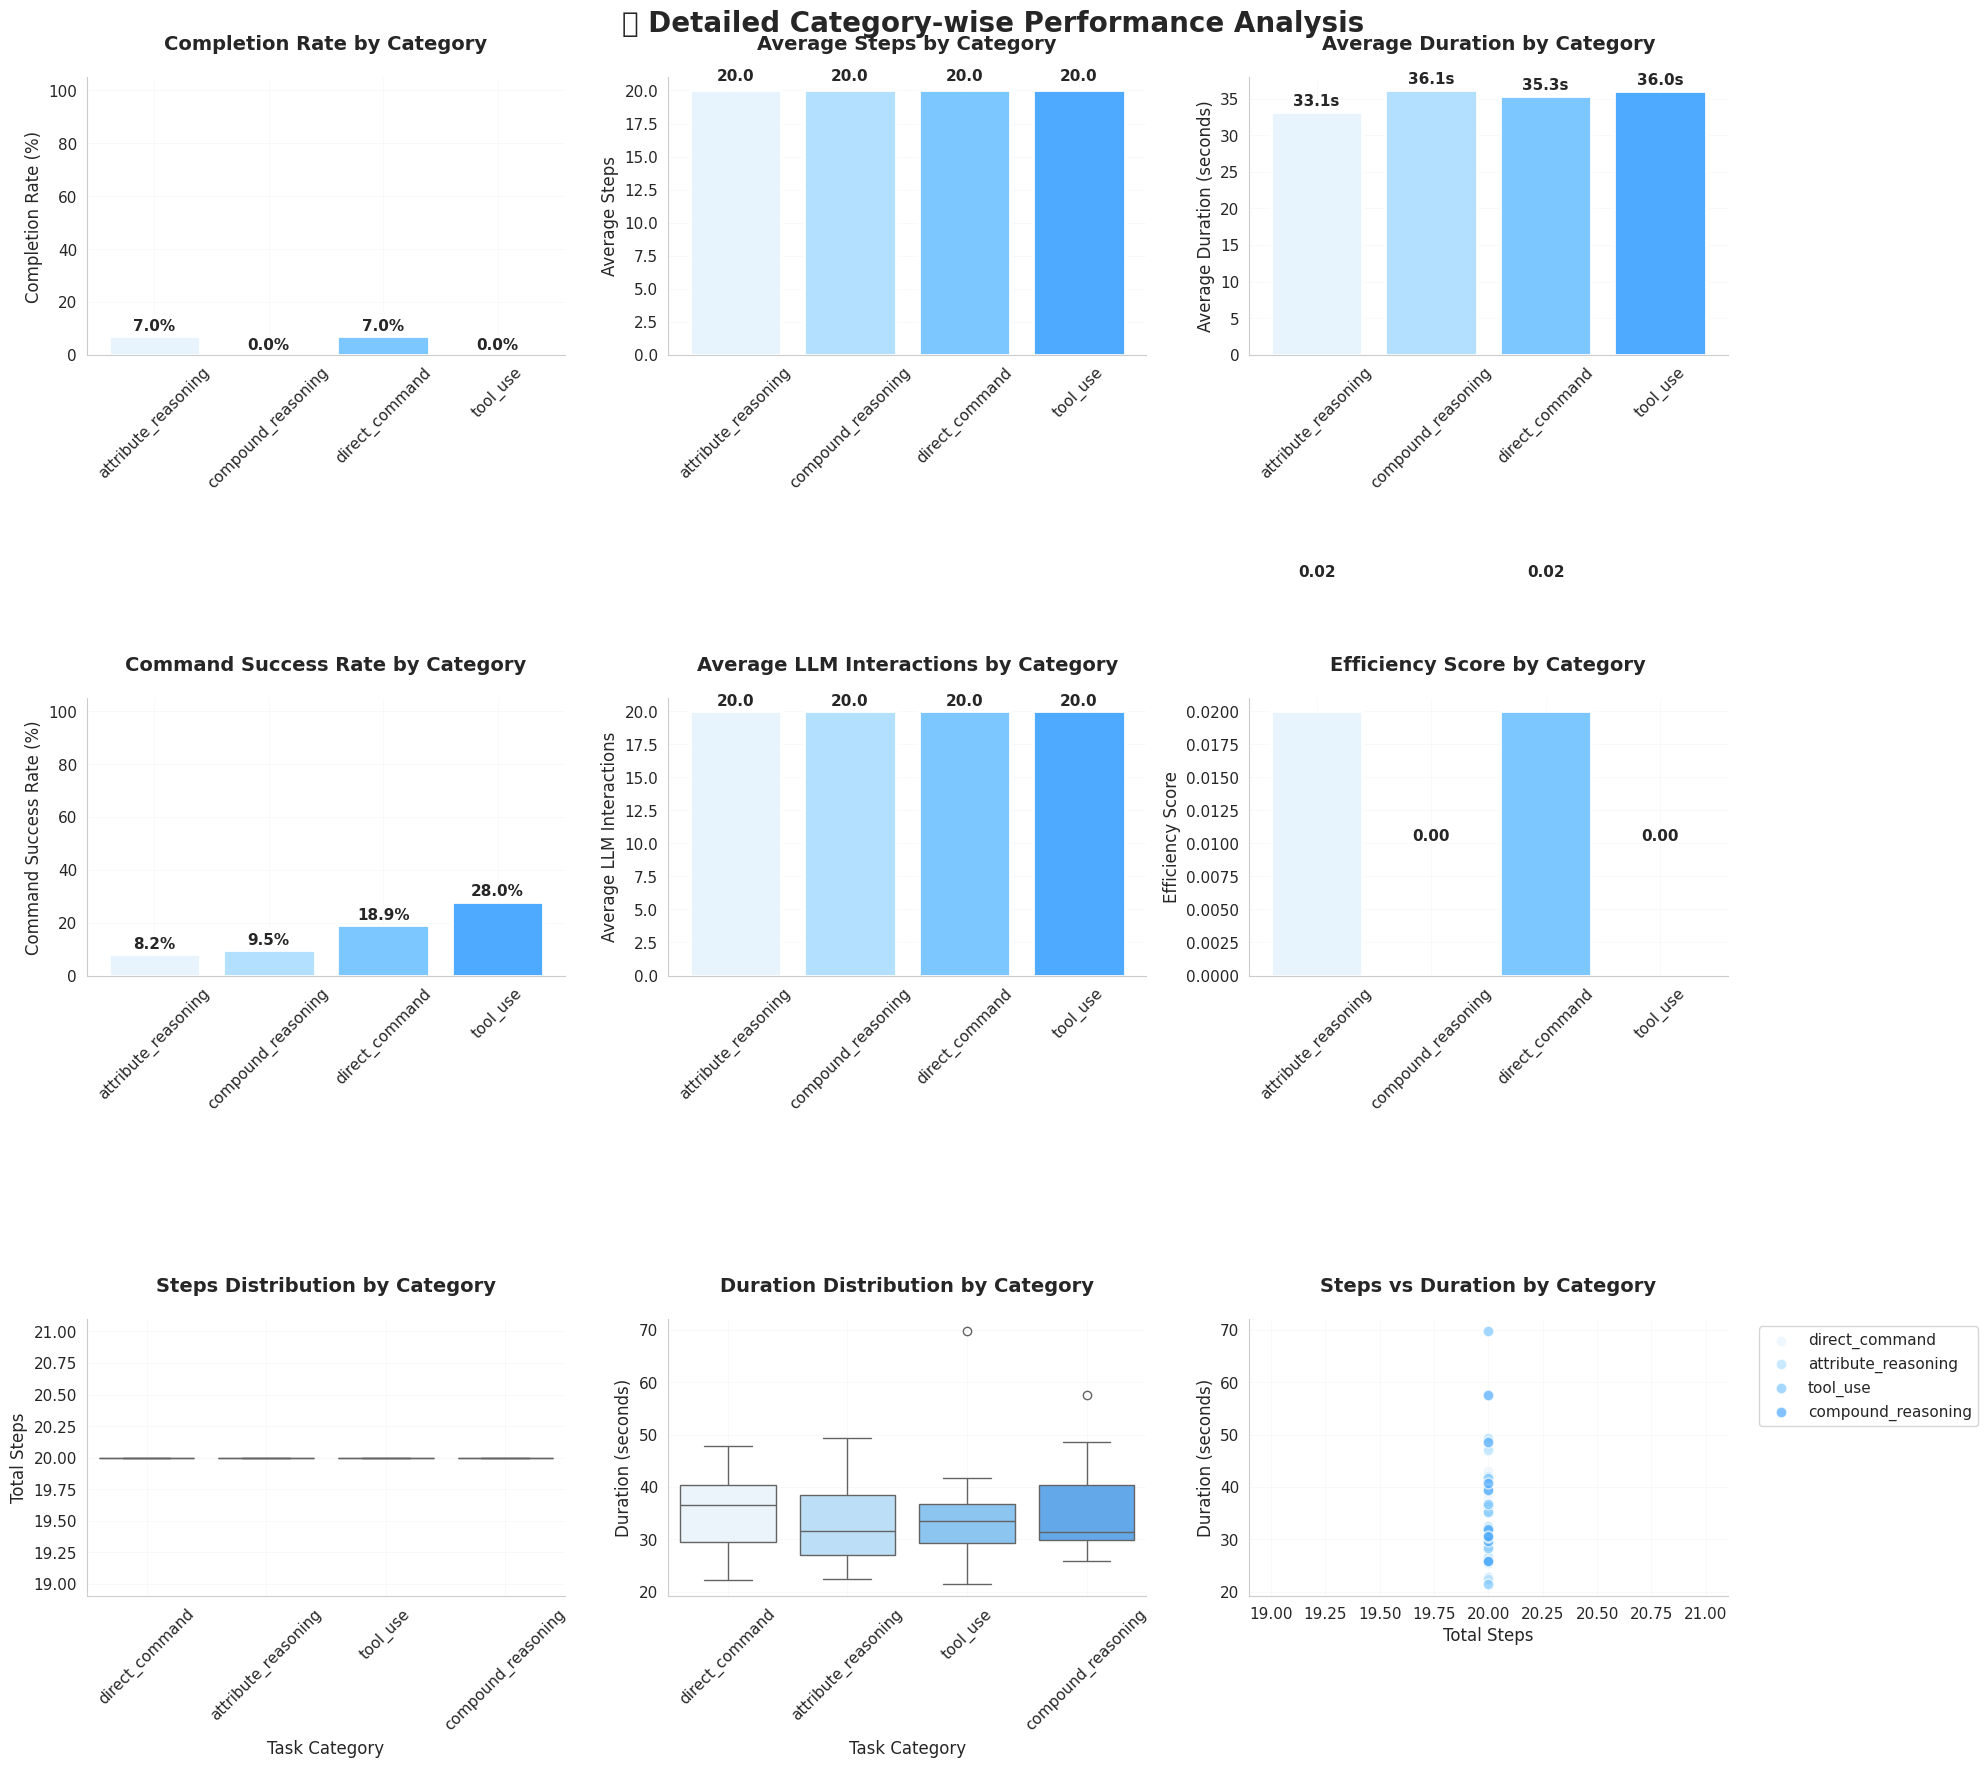

In [50]:
def analyze_detailed_category_stats(df):
    """
    Detailed statistical analysis for each task category and agent type
    """
    print("\n" + "="*80)
    print("📊 DETAILED CATEGORY-WISE STATISTICAL ANALYSIS")
    print("="*80)
    
    # 1. Comprehensive statistics by category
    print("\n📋 1. COMPREHENSIVE STATISTICS BY TASK CATEGORY")
    print("-" * 60)
    
    category_detailed_stats = df.groupby('task_category').agg({
        'subtask_completed': ['count', 'sum', 'mean'],
        'total_steps': ['mean', 'std', 'min', 'max'],
        'duration_seconds': ['mean', 'std', 'min', 'max'],
        'command_success_rate_numeric': ['mean', 'std', 'min', 'max'],
        'llm_interactions': ['mean', 'std', 'min', 'max'],
        'efficiency_score': ['mean', 'std']
    }).round(2)
    
    # Flatten column names
    category_detailed_stats.columns = ['_'.join(col).strip() for col in category_detailed_stats.columns]
    
    # Create summary table
    category_summary_table = pd.DataFrame({
        'Total_Tasks': category_detailed_stats['subtask_completed_count'],
        'Completed': category_detailed_stats['subtask_completed_sum'],
        'Completion_Rate_%': (category_detailed_stats['subtask_completed_mean'] * 100).round(1),
        'Avg_Steps': category_detailed_stats['total_steps_mean'],
        'Avg_Duration_s': category_detailed_stats['duration_seconds_mean'],
        'Avg_Cmd_Success_%': category_detailed_stats['command_success_rate_numeric_mean'],
        'Avg_LLM_Interactions': category_detailed_stats['llm_interactions_mean'],
        'Efficiency_Score': category_detailed_stats['efficiency_score_mean']
    })
    
    print(category_summary_table.to_string())
    
    # 2. Agent type analysis (if multiple agent types exist)
    if len(df['agent_type'].unique()) > 1:
        print("\n🤖 2. COMPREHENSIVE STATISTICS BY AGENT TYPE")
        print("-" * 60)
        
        agent_detailed_stats = df.groupby('agent_type').agg({
            'subtask_completed': ['count', 'sum', 'mean'],
            'total_steps': ['mean', 'std'],
            'duration_seconds': ['mean', 'std'],
            'command_success_rate_numeric': ['mean', 'std'],
            'llm_interactions': ['mean', 'std'],
            'efficiency_score': ['mean', 'std']
        }).round(2)
        
        agent_detailed_stats.columns = ['_'.join(col).strip() for col in agent_detailed_stats.columns]
        
        agent_summary_table = pd.DataFrame({
            'Total_Tasks': agent_detailed_stats['subtask_completed_count'],
            'Completed': agent_detailed_stats['subtask_completed_sum'],
            'Completion_Rate_%': (agent_detailed_stats['subtask_completed_mean'] * 100).round(1),
            'Avg_Steps': agent_detailed_stats['total_steps_mean'],
            'Avg_Duration_s': agent_detailed_stats['duration_seconds_mean'],
            'Avg_Cmd_Success_%': agent_detailed_stats['command_success_rate_numeric_mean'],
            'Avg_LLM_Interactions': agent_detailed_stats['llm_interactions_mean'],
            'Efficiency_Score': agent_detailed_stats['efficiency_score_mean']
        })
        
        print(agent_summary_table.to_string())
    else:
        print(f"\n🤖 2. SINGLE AGENT TYPE DETECTED: {df['agent_type'].unique()[0]}")
        print("   All statistics above apply to this agent type.")
    
    # 3. Create detailed visualization dashboard
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.patch.set_facecolor('white')
    fig.suptitle('📊 Detailed Category-wise Performance Analysis', fontsize=20, fontweight='bold', y=0.98)
    
    categories = df['task_category'].unique()
    colors = LIGHT_COLORS['primary'][:len(categories)] if len(categories) <= 6 else sns.color_palette("husl", len(categories))
    
    # 1. Completion Rate by Category (Bar Chart)
    ax1 = axes[0, 0]
    completion_rates = category_summary_table['Completion_Rate_%']
    bars1 = ax1.bar(completion_rates.index, completion_rates.values, 
                    color=colors, edgecolor='white', linewidth=2)
    ax1.set_title('Completion Rate by Category', fontweight='bold', pad=20)
    ax1.set_ylabel('Completion Rate (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim(0, 105)
    ax1.grid(True, alpha=0.3)
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Average Steps by Category
    ax2 = axes[0, 1]
    avg_steps = category_summary_table['Avg_Steps']
    bars2 = ax2.bar(avg_steps.index, avg_steps.values, 
                    color=colors, edgecolor='white', linewidth=2)
    ax2.set_title('Average Steps by Category', fontweight='bold', pad=20)
    ax2.set_ylabel('Average Steps')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Average Duration by Category
    ax3 = axes[0, 2]
    avg_duration = category_summary_table['Avg_Duration_s']
    bars3 = ax3.bar(avg_duration.index, avg_duration.values, 
                    color=colors, edgecolor='white', linewidth=2)
    ax3.set_title('Average Duration by Category', fontweight='bold', pad=20)
    ax3.set_ylabel('Average Duration (seconds)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 4. Command Success Rate by Category
    ax4 = axes[1, 0]
    cmd_success = category_summary_table['Avg_Cmd_Success_%']
    bars4 = ax4.bar(cmd_success.index, cmd_success.values, 
                    color=colors, edgecolor='white', linewidth=2)
    ax4.set_title('Command Success Rate by Category', fontweight='bold', pad=20)
    ax4.set_ylabel('Command Success Rate (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylim(0, 105)
    ax4.grid(True, alpha=0.3)
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 5. LLM Interactions by Category
    ax5 = axes[1, 1]
    llm_interactions = category_summary_table['Avg_LLM_Interactions']
    bars5 = ax5.bar(llm_interactions.index, llm_interactions.values, 
                    color=colors, edgecolor='white', linewidth=2)
    ax5.set_title('Average LLM Interactions by Category', fontweight='bold', pad=20)
    ax5.set_ylabel('Average LLM Interactions')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    for bar in bars5:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                 f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Efficiency Score by Category
    ax6 = axes[1, 2]
    efficiency = category_summary_table['Efficiency_Score']
    bars6 = ax6.bar(efficiency.index, efficiency.values, 
                    color=colors, edgecolor='white', linewidth=2)
    ax6.set_title('Efficiency Score by Category', fontweight='bold', pad=20)
    ax6.set_ylabel('Efficiency Score')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(True, alpha=0.3)
    for bar in bars6:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 7. Steps Distribution by Category (Box Plot)
    ax7 = axes[2, 0]
    sns.boxplot(data=df, x='task_category', y='total_steps', ax=ax7, 
                palette=colors)
    ax7.set_title('Steps Distribution by Category', fontweight='bold', pad=20)
    ax7.set_xlabel('Task Category')
    ax7.set_ylabel('Total Steps')
    ax7.tick_params(axis='x', rotation=45)
    ax7.grid(True, alpha=0.3)
    
    # 8. Duration Distribution by Category (Box Plot)
    ax8 = axes[2, 1]
    sns.boxplot(data=df, x='task_category', y='duration_seconds', ax=ax8,
                palette=colors)
    ax8.set_title('Duration Distribution by Category', fontweight='bold', pad=20)
    ax8.set_xlabel('Task Category')
    ax8.set_ylabel('Duration (seconds)')
    ax8.tick_params(axis='x', rotation=45)
    ax8.grid(True, alpha=0.3)
    
    # 9. Scatter plot: Steps vs Duration by Category
    ax9 = axes[2, 2]
    for i, category in enumerate(categories):
        cat_data = df[df['task_category'] == category]
        ax9.scatter(cat_data['total_steps'], cat_data['duration_seconds'],
                   alpha=0.7, color=colors[i], label=category, s=60,
                   edgecolors='white', linewidth=1)
    ax9.set_title('Steps vs Duration by Category', fontweight='bold', pad=20)
    ax9.set_xlabel('Total Steps')
    ax9.set_ylabel('Duration (seconds)')
    ax9.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax9.grid(True, alpha=0.3)
    
    return fig, {
        'category_detailed_stats': category_summary_table,
        'agent_stats': agent_summary_table if len(df['agent_type'].unique()) > 1 else None
    }

# Generate detailed category statistics
detailed_stats_fig, detailed_stats_data = analyze_detailed_category_stats(df)
plt.tight_layout()
plt.show()

## 🥧 Completion Rate Analysis with Pie Charts


🥧 COMPLETION RATE PIE CHART ANALYSIS


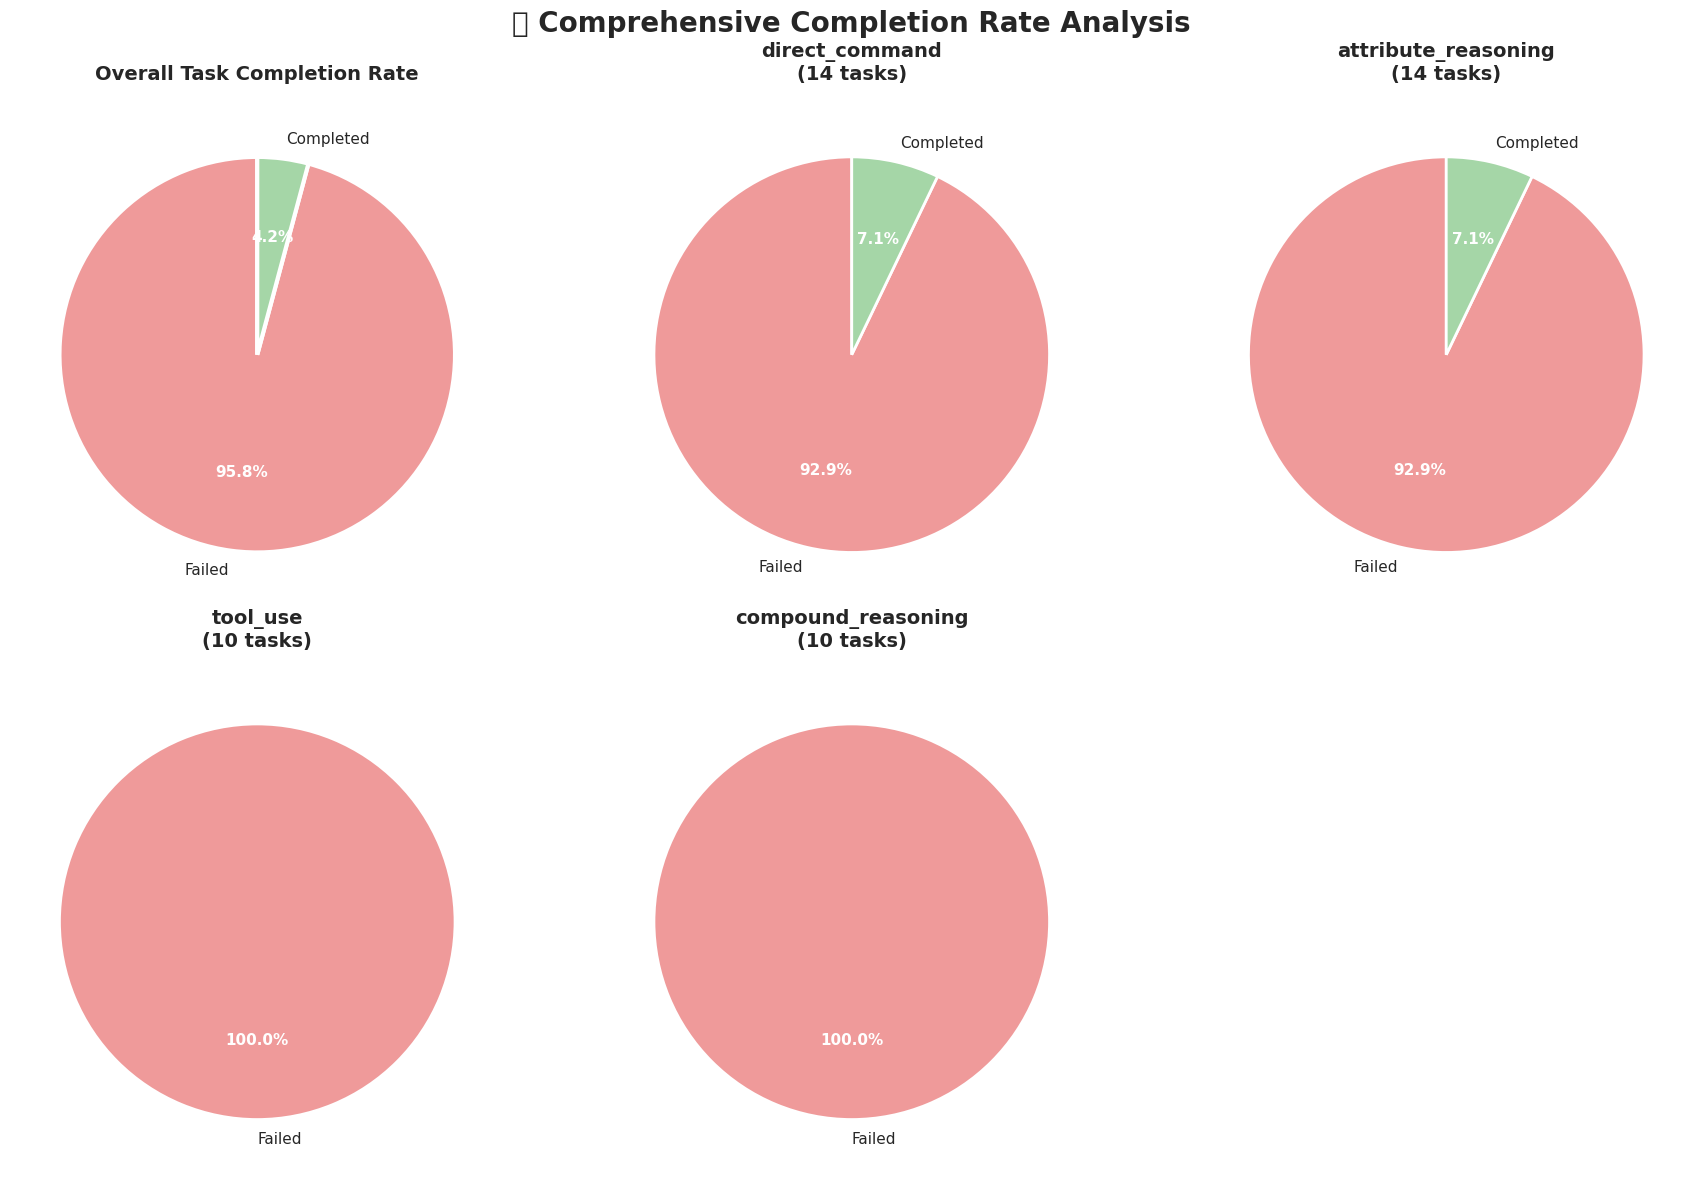

In [51]:
def create_completion_pie_charts(df):
    """
    Create comprehensive pie chart analysis for completion rates
    """
    print("\n" + "="*60)
    print("🥧 COMPLETION RATE PIE CHART ANALYSIS")
    print("="*60)
    
    # Create pie chart dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.patch.set_facecolor('white')
    fig.suptitle('🥧 Comprehensive Completion Rate Analysis', fontsize=20, fontweight='bold', y=0.98)
    
    # 1. Overall Completion Rate
    ax1 = axes[0, 0]
    overall_completion = df['subtask_completed'].value_counts()
    colors_overall = [LIGHT_COLORS['error'][2], LIGHT_COLORS['success'][2]]
    labels_overall = ['Failed', 'Completed']
    wedges1, texts1, autotexts1 = ax1.pie(overall_completion.values, labels=labels_overall,
                                          autopct='%1.1f%%', colors=colors_overall, startangle=90,
                                          wedgeprops=dict(edgecolor='white', linewidth=3))
    ax1.set_title('Overall Task Completion Rate', fontweight='bold', pad=20)
    for autotext in autotexts1:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 2. Completion Rate by Category
    categories = df['task_category'].unique()
    category_colors = LIGHT_COLORS['primary'][:len(categories)] if len(categories) <= 6 else sns.color_palette("husl", len(categories))
    
    for i, category in enumerate(categories[:4]):  # Show up to 4 categories
        row = (i + 1) // 3
        col = (i + 1) % 3
        ax = axes[row, col]
        
        cat_data = df[df['task_category'] == category]
        cat_completion = cat_data['subtask_completed'].value_counts()
        
        if len(cat_completion) == 2:
            colors_cat = [LIGHT_COLORS['error'][2], LIGHT_COLORS['success'][2]]
            labels_cat = ['Failed', 'Completed']
        else:
            # Handle case where all tasks are completed or all failed
            if cat_completion.index[0] == True:
                colors_cat = [LIGHT_COLORS['success'][2]]
                labels_cat = ['Completed']
            else:
                colors_cat = [LIGHT_COLORS['error'][2]]
                labels_cat = ['Failed']
        
        wedges, texts, autotexts = ax.pie(cat_completion.values, labels=labels_cat,
                                         autopct='%1.1f%%', colors=colors_cat, startangle=90,
                                         wedgeprops=dict(edgecolor='white', linewidth=2))
        ax.set_title(f'{category}\n({len(cat_data)} tasks)', fontweight='bold', pad=20)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    
    # If there are remaining categories, show them in the last subplot
    if len(categories) > 4:
        ax_last = axes[1, 2]
        remaining_categories = categories[4:]
        remaining_data = df[df['task_category'].isin(remaining_categories)]
        remaining_completion = remaining_data['subtask_completed'].value_counts()
        
        colors_remaining = [LIGHT_COLORS['error'][2], LIGHT_COLORS['success'][2]]
        labels_remaining = ['Failed', 'Completed']
        wedges, texts, autotexts = ax_last.pie(remaining_completion.values, labels=labels_remaining,
                                              autopct='%1.1f%%', colors=colors_remaining, startangle=90,
                                              wedgeprops=dict(edgecolor='white', linewidth=2))
        ax_last.set_title(f'Other Categories\n({len(remaining_data)} tasks)', fontweight='bold', pad=20)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    
    # Hide empty subplots
    for i in range(len(categories) + 1, 6):
        row = i // 3
        col = i % 3
        if row < 2 and col < 3:
            axes[row, col].set_visible(False)
    
    return fig

# Generate completion rate pie charts
pie_charts_fig = create_completion_pie_charts(df)
plt.tight_layout()
plt.show()

## 🔍 Multi-Dimensional Analysis


🔍 DETAILED MULTI-DIMENSIONAL ANALYSIS

🤖 1. PERFORMANCE BY AGENT TYPE
----------------------------------------
              Total_Tasks  Completed  Completion_Rate  Avg_Steps  \
agent_type                                                         
single_agent           48          2              4.0       20.0   

              Avg_Duration  Avg_Cmd_Success  
agent_type                                   
single_agent         34.99            15.73  

🔄 2. CROSS-ANALYSIS: COMPLETION RATE BY CATEGORY & AGENT TYPE
------------------------------------------------------------
agent_type           single_agent
task_category                    
attribute_reasoning           7.1
compound_reasoning            0.0
direct_command                7.1
tool_use                      0.0

📈 3. PERFORMANCE BY EXECUTION STATUS
----------------------------------------
        Total_Tasks  Completed  Completion_Rate  Avg_Steps  Avg_Duration  \
status                                                        

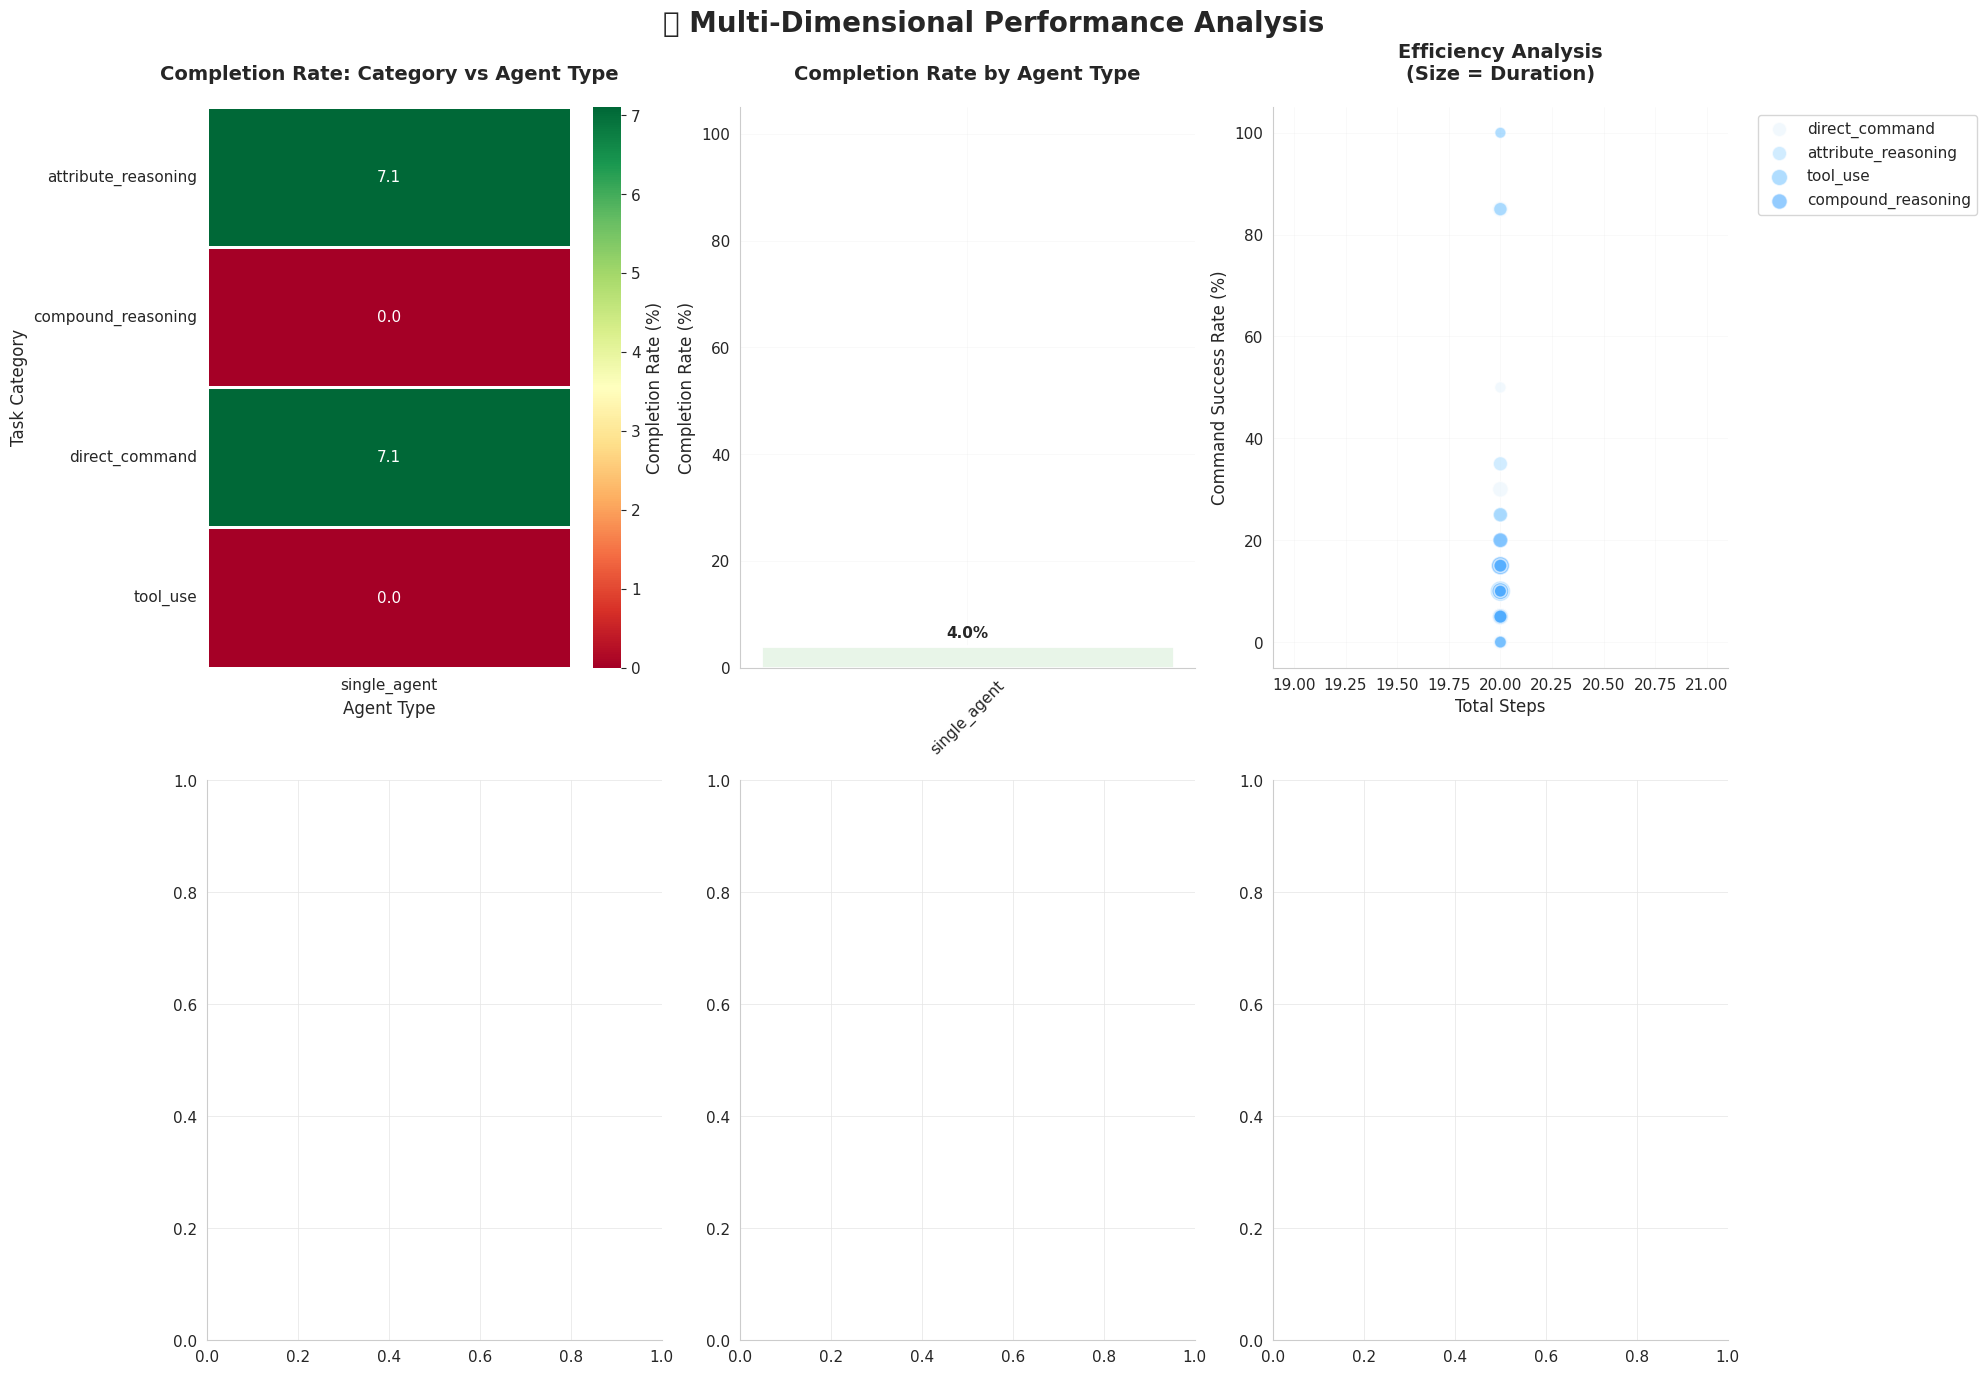

In [52]:
def analyze_multi_dimensional(df):
    """
    Perform detailed multi-dimensional analysis with cross-tabulation and correlations
    """
    print("\n" + "="*60)
    print("🔍 DETAILED MULTI-DIMENSIONAL ANALYSIS")
    print("="*60)
    
    # 1. By Agent Type
    print("\n🤖 1. PERFORMANCE BY AGENT TYPE")
    print("-" * 40)
    agent_stats = df.groupby('agent_type').agg({
        'subtask_completed': ['count', 'sum', 'mean'],
        'total_steps': ['mean', 'std'],
        'duration_seconds': ['mean', 'std'],
        'command_success_rate_numeric': ['mean', 'std'],
        'llm_interactions': ['mean', 'std']
    }).round(2)
    
    agent_stats.columns = ['_'.join(col).strip() for col in agent_stats.columns]
    agent_summary = agent_stats[['subtask_completed_count', 'subtask_completed_sum', 'subtask_completed_mean',
                                'total_steps_mean', 'duration_seconds_mean', 'command_success_rate_numeric_mean']]
    agent_summary.columns = ['Total_Tasks', 'Completed', 'Completion_Rate', 
                            'Avg_Steps', 'Avg_Duration', 'Avg_Cmd_Success']
    agent_summary['Completion_Rate'] = (agent_summary['Completion_Rate'] * 100).round(1)
    print(agent_summary)
    
    # 2. Cross-tabulation: Category vs Agent Type
    print("\n🔄 2. CROSS-ANALYSIS: COMPLETION RATE BY CATEGORY & AGENT TYPE")
    print("-" * 60)
    cross_completion = pd.crosstab(df['task_category'], df['agent_type'], 
                                  values=df['subtask_completed'], aggfunc='mean') * 100
    cross_completion = cross_completion.round(1)
    print(cross_completion)
    
    # 3. Performance by Status
    print("\n📈 3. PERFORMANCE BY EXECUTION STATUS")
    print("-" * 40)
    status_stats = df.groupby('status').agg({
        'subtask_completed': ['count', 'sum', 'mean'],
        'total_steps': 'mean',
        'duration_seconds': 'mean',
        'command_success_rate_numeric': 'mean'
    }).round(2)
    
    status_stats.columns = ['_'.join(col).strip() for col in status_stats.columns]
    status_summary = status_stats[['subtask_completed_count', 'subtask_completed_sum', 'subtask_completed_mean',
                                  'total_steps_mean', 'duration_seconds_mean', 'command_success_rate_numeric_mean']]
    status_summary.columns = ['Total_Tasks', 'Completed', 'Completion_Rate', 
                             'Avg_Steps', 'Avg_Duration', 'Avg_Cmd_Success']
    status_summary['Completion_Rate'] = (status_summary['Completion_Rate'] * 100).round(1)
    print(status_summary)
    
    # Create multi-dimensional visualization dashboard
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.patch.set_facecolor('white')
    fig.suptitle('🔍 Multi-Dimensional Performance Analysis', fontsize=20, fontweight='bold', y=0.98)
    
    # 1. Cross-tabulation Heatmap
    ax1 = axes[0, 0]
    sns.heatmap(cross_completion, annot=True, fmt='.1f', cmap='RdYlGn', 
                cbar_kws={'label': 'Completion Rate (%)'}, ax=ax1,
                linewidths=1, linecolor='white')
    ax1.set_title('Completion Rate: Category vs Agent Type', fontweight='bold', pad=20)
    ax1.set_xlabel('Agent Type')
    ax1.set_ylabel('Task Category')
    
    # 2. Agent Type Performance Comparison
    ax2 = axes[0, 1]
    agent_types = agent_summary.index
    x_pos = np.arange(len(agent_types))
    bars2 = ax2.bar(x_pos, agent_summary['Completion_Rate'], 
                    color=LIGHT_COLORS['success'][:len(agent_types)],
                    edgecolor='white', linewidth=2)
    ax2.set_title('Completion Rate by Agent Type', fontweight='bold', pad=20)
    ax2.set_ylabel('Completion Rate (%)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(agent_types, rotation=45)
    ax2.set_ylim(0, 105)
    ax2.grid(True, alpha=0.3)
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Efficiency Bubble Chart
    ax3 = axes[0, 2]
    categories = df['task_category'].unique()
    colors = LIGHT_COLORS['primary'][:len(categories)]
    for i, category in enumerate(categories):
        cat_data = df[df['task_category'] == category]
        ax3.scatter(cat_data['total_steps'], cat_data['command_success_rate_numeric'],
                   s=cat_data['duration_seconds']*3, alpha=0.6, color=colors[i],
                   label=category, edgecolors='white', linewidth=1)
    ax3.set_title('Efficiency Analysis\n(Size = Duration)', fontweight='bold', pad=20)
    ax3.set_xlabel('Total Steps')
    ax3.set_ylabel('Command Success Rate (%)')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    return fig, {
        'agent_stats': agent_summary,
        'cross_completion': cross_completion,
        'status_stats': status_summary
    }

# Generate multi-dimensional analysis
multi_dim_fig, multi_dim_stats = analyze_multi_dimensional(df)
plt.tight_layout()
plt.show()

## ⚠️ Bad Case Analysis & Failure Patterns


⚠️ BAD CASE ANALYSIS & FAILURE PATTERNS
❌ Total Failed Tasks: 46 (95.8%)
✅ Total Successful Tasks: 2 (4.2%)

📊 FAILURE ANALYSIS BY CATEGORY
----------------------------------------
                     Total_Tasks  Failed_Tasks  Failure_Rate
task_category                                               
compound_reasoning            10            10         100.0
tool_use                      10            10         100.0
attribute_reasoning           14            13          92.9
direct_command                14            13          92.9

🔍 FAILED vs SUCCESSFUL TASKS COMPARISON
--------------------------------------------------
                      Failed_Tasks  Successful_Tasks  Difference
Avg_Steps                    20.00             20.00         0.0
Avg_Duration                 35.05             33.65         1.4
Avg_Cmd_Success              16.20              5.00        11.2
Avg_LLM_Interactions         20.00             20.00         0.0


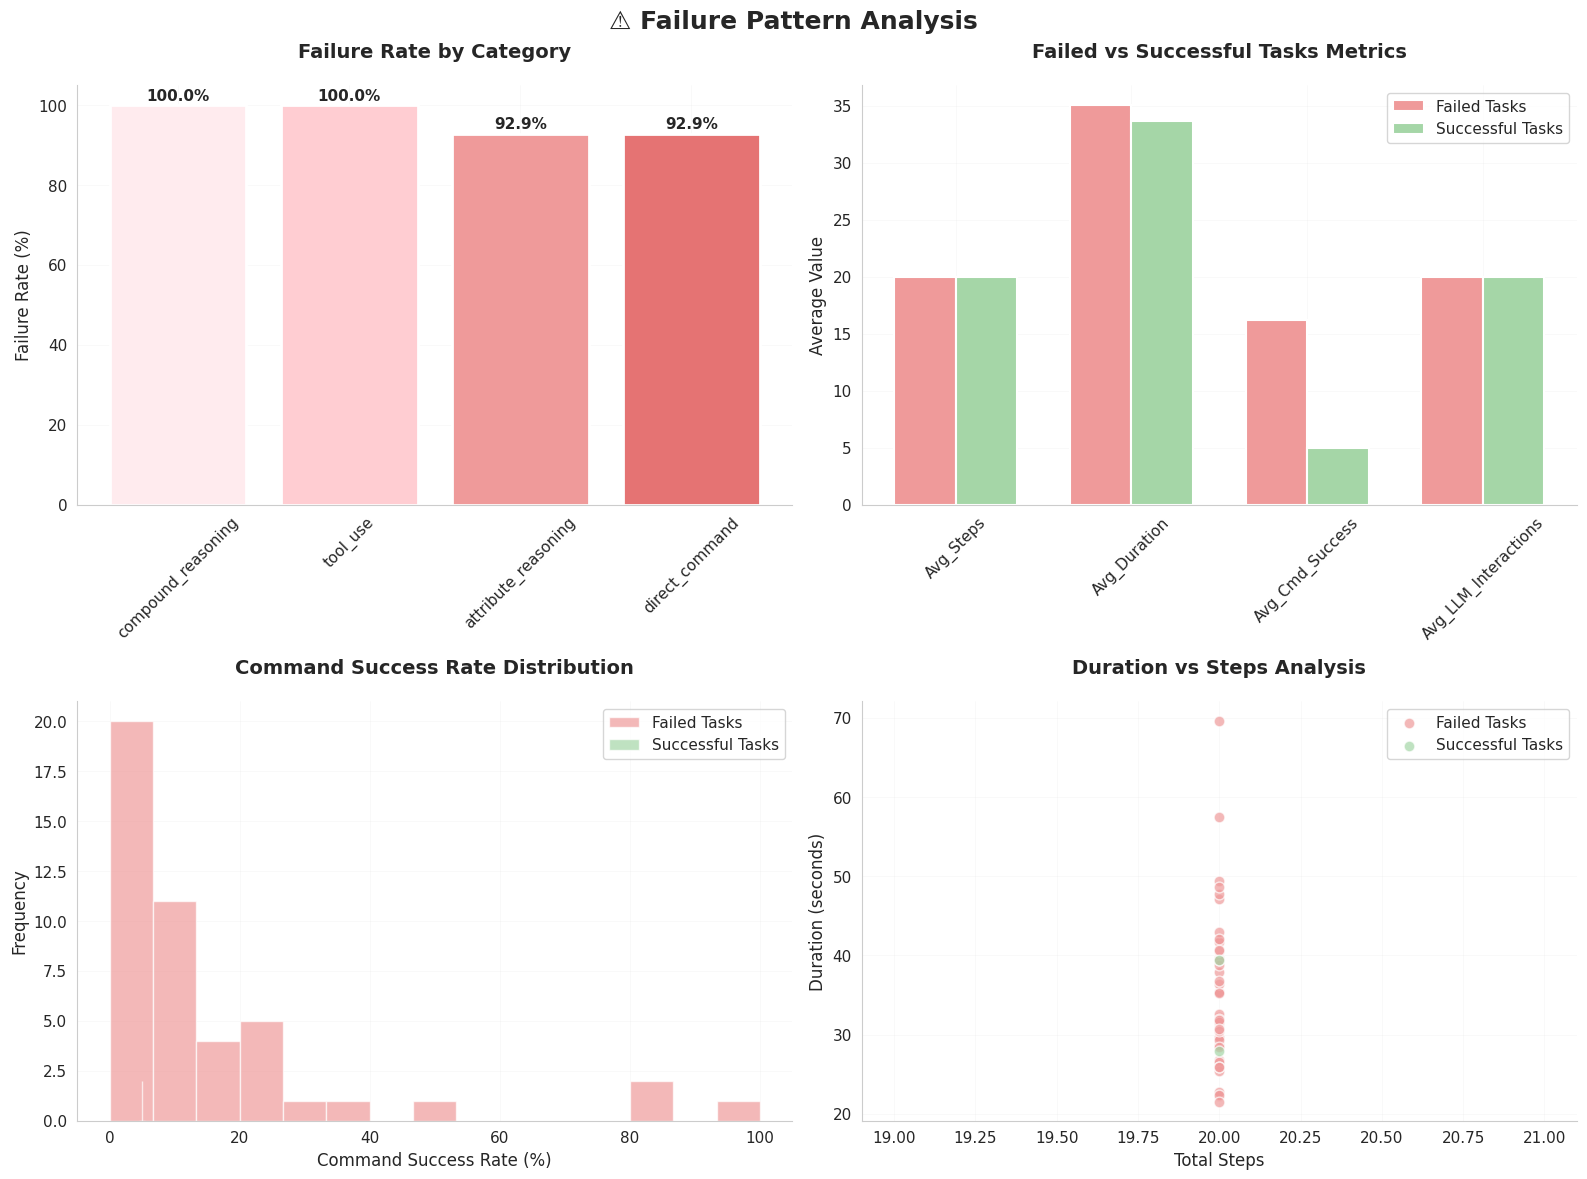

In [53]:
def analyze_bad_cases(df):
    """
    Analyze failed tasks and identify failure patterns
    """
    print("\n" + "="*60)
    print("⚠️ BAD CASE ANALYSIS & FAILURE PATTERNS")
    print("="*60)
    
    # Identify failed tasks
    failed_tasks = df[df['subtask_completed'] == False]
    successful_tasks = df[df['subtask_completed'] == True]
    
    print(f"❌ Total Failed Tasks: {len(failed_tasks)} ({len(failed_tasks)/len(df)*100:.1f}%)")
    print(f"✅ Total Successful Tasks: {len(successful_tasks)} ({len(successful_tasks)/len(df)*100:.1f}%)")
    
    if len(failed_tasks) == 0:
        print("🎉 No failed tasks found! All tasks completed successfully.")
        return None, None
    
    # Failure analysis by category
    print("\n📊 FAILURE ANALYSIS BY CATEGORY")
    print("-" * 40)
    failure_by_category = failed_tasks['task_category'].value_counts()
    total_by_category = df['task_category'].value_counts()
    failure_rate_by_category = (failure_by_category / total_by_category * 100).fillna(0).round(1)
    
    failure_analysis = pd.DataFrame({
        'Total_Tasks': total_by_category,
        'Failed_Tasks': failure_by_category.fillna(0).astype(int),
        'Failure_Rate': failure_rate_by_category
    }).sort_values('Failure_Rate', ascending=False)
    
    print(failure_analysis)
    
    # Compare failed vs successful tasks
    print("\n🔍 FAILED vs SUCCESSFUL TASKS COMPARISON")
    print("-" * 50)
    comparison = pd.DataFrame({
        'Failed_Tasks': [
            failed_tasks['total_steps'].mean(),
            failed_tasks['duration_seconds'].mean(),
            failed_tasks['command_success_rate_numeric'].mean(),
            failed_tasks['llm_interactions'].mean()
        ],
        'Successful_Tasks': [
            successful_tasks['total_steps'].mean(),
            successful_tasks['duration_seconds'].mean(),
            successful_tasks['command_success_rate_numeric'].mean(),
            successful_tasks['llm_interactions'].mean()
        ]
    }, index=['Avg_Steps', 'Avg_Duration', 'Avg_Cmd_Success', 'Avg_LLM_Interactions']).round(2)
    
    comparison['Difference'] = (comparison['Failed_Tasks'] - comparison['Successful_Tasks']).round(2)
    print(comparison)
    
    # Create failure analysis visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('white')
    fig.suptitle('⚠️ Failure Pattern Analysis', fontsize=18, fontweight='bold', y=0.98)
    
    # 1. Failure Rate by Category
    ax1 = axes[0, 0]
    bars1 = ax1.bar(failure_analysis.index, failure_analysis['Failure_Rate'],
                    color=LIGHT_COLORS['error'][:len(failure_analysis)],
                    edgecolor='white', linewidth=2)
    ax1.set_title('Failure Rate by Category', fontweight='bold', pad=20)
    ax1.set_ylabel('Failure Rate (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 2. Failed vs Successful Comparison
    ax2 = axes[0, 1]
    x_pos = np.arange(len(comparison.index))
    width = 0.35
    bars2a = ax2.bar(x_pos - width/2, comparison['Failed_Tasks'], width, 
                     label='Failed Tasks', color=LIGHT_COLORS['error'][2],
                     edgecolor='white', linewidth=1.5)
    bars2b = ax2.bar(x_pos + width/2, comparison['Successful_Tasks'], width,
                     label='Successful Tasks', color=LIGHT_COLORS['success'][2],
                     edgecolor='white', linewidth=1.5)
    ax2.set_title('Failed vs Successful Tasks Metrics', fontweight='bold', pad=20)
    ax2.set_ylabel('Average Value')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(comparison.index, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Command Success Rate Distribution
    ax3 = axes[1, 0]
    ax3.hist(failed_tasks['command_success_rate_numeric'], bins=15, alpha=0.7, 
             label='Failed Tasks', color=LIGHT_COLORS['error'][2], edgecolor='white')
    ax3.hist(successful_tasks['command_success_rate_numeric'], bins=15, alpha=0.7,
             label='Successful Tasks', color=LIGHT_COLORS['success'][2], edgecolor='white')
    ax3.set_title('Command Success Rate Distribution', fontweight='bold', pad=20)
    ax3.set_xlabel('Command Success Rate (%)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Duration vs Steps Scatter
    ax4 = axes[1, 1]
    ax4.scatter(failed_tasks['total_steps'], failed_tasks['duration_seconds'],
               alpha=0.7, color=LIGHT_COLORS['error'][2], label='Failed Tasks',
               s=60, edgecolors='white', linewidth=1)
    ax4.scatter(successful_tasks['total_steps'], successful_tasks['duration_seconds'],
               alpha=0.7, color=LIGHT_COLORS['success'][2], label='Successful Tasks',
               s=60, edgecolors='white', linewidth=1)
    ax4.set_title('Duration vs Steps Analysis', fontweight='bold', pad=20)
    ax4.set_xlabel('Total Steps')
    ax4.set_ylabel('Duration (seconds)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    return fig, {
        'failure_analysis': failure_analysis,
        'comparison': comparison,
        'failed_tasks': failed_tasks,
        'successful_tasks': successful_tasks
    }

# Generate bad case analysis
bad_case_fig, bad_case_stats = analyze_bad_cases(df)
if bad_case_fig is not None:
    plt.tight_layout()
    plt.show()

## 🎨 Interactive Visualizations with Plotly

In [54]:
def create_interactive_dashboard(df):
    """
    Create interactive visualizations using Plotly
    """
    print("\n" + "="*60)
    print("🎨 INTERACTIVE VISUALIZATIONS")
    print("="*60)
    
    # 1. Interactive Completion Rate by Category
    category_completion = df.groupby('task_category')['subtask_completed'].agg(['count', 'sum', 'mean']).reset_index()
    category_completion['completion_rate'] = category_completion['mean'] * 100
    
    fig1 = px.bar(category_completion, x='task_category', y='completion_rate',
                  title='📊 Interactive Completion Rate by Task Category',
                  labels={'completion_rate': 'Completion Rate (%)', 'task_category': 'Task Category'},
                  color='completion_rate',
                  color_continuous_scale='RdYlGn',
                  hover_data={'count': True, 'sum': True})
    fig1.update_layout(height=500, showlegend=False, 
                       font=dict(size=12),
                       plot_bgcolor='white',
                       paper_bgcolor='white')
    fig1.show()
    
    # 2. Interactive Scatter Plot: Steps vs Success Rate
    fig2 = px.scatter(df, x='total_steps', y='command_success_rate_numeric',
                      color='task_category', size='duration_seconds',
                      hover_data=['scenario_id', 'agent_type', 'subtask_completed'],
                      title='🔍 Interactive Analysis: Steps vs Command Success Rate',
                      labels={'command_success_rate_numeric': 'Command Success Rate (%)',
                             'total_steps': 'Total Steps'})
    fig2.update_layout(height=600,
                       font=dict(size=12),
                       plot_bgcolor='white',
                       paper_bgcolor='white')
    fig2.show()
    
    # 3. Interactive Heatmap: Category vs Agent Type
    if len(df['agent_type'].unique()) > 1:
        cross_completion = pd.crosstab(df['task_category'], df['agent_type'], 
                                      values=df['subtask_completed'], aggfunc='mean') * 100
        
        fig3 = px.imshow(cross_completion.values,
                         x=cross_completion.columns,
                         y=cross_completion.index,
                         color_continuous_scale='RdYlGn',
                         title='🔄 Interactive Cross-Analysis: Category vs Agent Type',
                         labels=dict(x="Agent Type", y="Task Category", color="Completion Rate (%)"))
        fig3.update_layout(height=500,
                           font=dict(size=12),
                           plot_bgcolor='white',
                           paper_bgcolor='white')
        fig3.show()
    
    # 4. Interactive Timeline Analysis
    df_timeline = df.copy()
    df_timeline['date'] = df_timeline['timestamp'].dt.date
    timeline_stats = df_timeline.groupby('date').agg({
        'subtask_completed': ['count', 'sum', 'mean']
    }).reset_index()
    timeline_stats.columns = ['date', 'total_tasks', 'completed_tasks', 'completion_rate']
    timeline_stats['completion_rate'] = timeline_stats['completion_rate'] * 100
    
    fig4 = px.line(timeline_stats, x='date', y='completion_rate',
                   title='📈 Interactive Timeline: Daily Completion Rate Trend',
                   labels={'completion_rate': 'Completion Rate (%)', 'date': 'Date'},
                   markers=True)
    fig4.add_scatter(x=timeline_stats['date'], y=timeline_stats['total_tasks'],
                     mode='markers', name='Total Tasks', yaxis='y2',
                     marker=dict(size=8, color='orange'))
    fig4.update_layout(height=500,
                       font=dict(size=12),
                       plot_bgcolor='white',
                       paper_bgcolor='white',
                       yaxis2=dict(title='Total Tasks', overlaying='y', side='right'))
    fig4.show()
    
    print("✅ Interactive visualizations generated successfully!")
    print("💡 Hover over data points for detailed information")
    print("🔍 Use zoom, pan, and selection tools for detailed exploration")

# Generate interactive visualizations
create_interactive_dashboard(df)


🎨 INTERACTIVE VISUALIZATIONS


✅ Interactive visualizations generated successfully!
💡 Hover over data points for detailed information
🔍 Use zoom, pan, and selection tools for detailed exploration


## 💡 Intelligent Insights & Recommendations

In [55]:
def generate_intelligent_insights(df, category_summary, multi_dim_stats, bad_case_stats):
    """
    Generate AI-powered insights and recommendations based on the analysis
    """
    print("\n" + "="*60)
    print("💡 INTELLIGENT INSIGHTS & RECOMMENDATIONS")
    print("="*60)
    
    insights = []
    recommendations = []
    
    # Overall performance insights
    total_completion_rate = df['subtask_completed'].mean() * 100
    avg_cmd_success = df['command_success_rate_numeric'].mean()
    
    if total_completion_rate >= 90:
        insights.append(f"🎉 Excellent overall performance with {total_completion_rate:.1f}% completion rate!")
    elif total_completion_rate >= 70:
        insights.append(f"👍 Good overall performance with {total_completion_rate:.1f}% completion rate.")
        recommendations.append("🎯 Focus on optimizing the remaining failure cases to reach excellence.")
    else:
        insights.append(f"⚠️ Performance needs improvement with {total_completion_rate:.1f}% completion rate.")
        recommendations.append("🚨 Urgent attention needed to identify and fix major issues.")
    
    # Category-specific insights
    best_category = category_summary['Completion_Rate'].idxmax()
    worst_category = category_summary['Completion_Rate'].idxmin()
    best_rate = category_summary.loc[best_category, 'Completion_Rate']
    worst_rate = category_summary.loc[worst_category, 'Completion_Rate']
    
    insights.append(f"🏆 '{best_category}' tasks perform best ({best_rate:.1f}% completion).")
    if worst_rate < 80:
        insights.append(f"⚠️ '{worst_category}' tasks need attention ({worst_rate:.1f}% completion).")
        recommendations.append(f"🔧 Investigate and optimize '{worst_category}' task execution logic.")
    
    # Command success vs task completion correlation
    correlation = df['command_success_rate_numeric'].corr(df['subtask_completed'].astype(int))
    if correlation > 0.7:
        insights.append(f"📈 Strong correlation ({correlation:.2f}) between command success and task completion.")
        recommendations.append("💡 Focus on improving command execution quality for better overall performance.")
    
    # Duration and efficiency insights
    avg_duration = df['duration_seconds'].mean()
    if avg_duration > 30:
        insights.append(f"⏱️ Tasks take relatively long on average ({avg_duration:.1f}s).")
        recommendations.append("⚡ Consider optimizing task execution speed and reducing unnecessary steps.")
    
    # Steps efficiency
    avg_steps = df['total_steps'].mean()
    successful_avg_steps = df[df['subtask_completed'] == True]['total_steps'].mean()
    failed_avg_steps = df[df['subtask_completed'] == False]['total_steps'].mean()
    
    if not pd.isna(failed_avg_steps) and failed_avg_steps > successful_avg_steps * 1.2:
        insights.append(f"🔍 Failed tasks use more steps on average ({failed_avg_steps:.1f} vs {successful_avg_steps:.1f}).")
        recommendations.append("🎯 Implement early failure detection to avoid unnecessary step execution.")
    
    # Agent type insights (if multiple types exist)
    if len(df['agent_type'].unique()) > 1:
        agent_performance = multi_dim_stats['agent_stats']['Completion_Rate']
        best_agent = agent_performance.idxmax()
        worst_agent = agent_performance.idxmin()
        insights.append(f"🤖 '{best_agent}' agents outperform '{worst_agent}' agents.")
        recommendations.append(f"📊 Analyze '{best_agent}' agent strategies for potential improvements to '{worst_agent}' agents.")
    
    # Print insights and recommendations
    print("\n🔍 KEY INSIGHTS:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    print("\n🎯 RECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    # Performance score calculation
    performance_score = (
        total_completion_rate * 0.4 +  # 40% weight on completion
        avg_cmd_success * 0.3 +        # 30% weight on command success
        (100 - min(avg_duration/60*10, 50)) * 0.2 +  # 20% weight on speed (capped)
        (100 - min(avg_steps/20*10, 50)) * 0.1       # 10% weight on efficiency (capped)
    )
    
    print(f"\n📊 OVERALL PERFORMANCE SCORE: {performance_score:.1f}/100")
    
    if performance_score >= 85:
        print("🌟 EXCELLENT - System is performing at a high level!")
    elif performance_score >= 70:
        print("👍 GOOD - System is performing well with room for optimization.")
    elif performance_score >= 50:
        print("⚠️ FAIR - System needs improvement in several areas.")
    else:
        print("🚨 POOR - System requires immediate attention and optimization.")
    
    return {
        'insights': insights,
        'recommendations': recommendations,
        'performance_score': performance_score
    }

# Generate intelligent insights
if bad_case_stats is not None:
    insights_data = generate_intelligent_insights(df, category_summary, multi_dim_stats, bad_case_stats)
else:
    insights_data = generate_intelligent_insights(df, category_summary, multi_dim_stats, {})


💡 INTELLIGENT INSIGHTS & RECOMMENDATIONS

🔍 KEY INSIGHTS:
1. ⚠️ Performance needs improvement with 4.2% completion rate.
2. 🏆 'attribute_reasoning' tasks perform best (7.1% completion).
3. ⚠️ 'compound_reasoning' tasks need attention (0.0% completion).
4. ⏱️ Tasks take relatively long on average (35.0s).

🎯 RECOMMENDATIONS:
1. 🚨 Urgent attention needed to identify and fix major issues.
2. 🔧 Investigate and optimize 'compound_reasoning' task execution logic.
3. ⚡ Consider optimizing task execution speed and reducing unnecessary steps.

📊 OVERALL PERFORMANCE SCORE: 34.2/100
🚨 POOR - System requires immediate attention and optimization.


## 📋 Executive Summary Report

In [56]:
def generate_executive_summary(df, insights_data):
    """
    Generate a comprehensive executive summary report
    """
    print("\n" + "="*80)
    print("📋 EXECUTIVE SUMMARY REPORT")
    print("="*80)
    
    # Header information
    print(f"📅 Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"📊 Analysis Period: {df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}")
    print(f"📈 Total Records Analyzed: {len(df):,}")
    print(f"🏆 Overall Performance Score: {insights_data['performance_score']:.1f}/100")
    
    # Key metrics summary
    print("\n" + "-"*50)
    print("📊 KEY PERFORMANCE METRICS")
    print("-"*50)
    
    total_completion_rate = df['subtask_completed'].mean() * 100
    execution_rate = df['task_executed'].mean() * 100
    avg_cmd_success = df['command_success_rate_numeric'].mean()
    avg_duration = df['duration_seconds'].mean()
    avg_steps = df['total_steps'].mean()
    avg_llm_interactions = df['llm_interactions'].mean()
    
    metrics_table = pd.DataFrame({
        'Metric': [
            'Task Completion Rate',
            'Task Execution Rate', 
            'Command Success Rate',
            'Average Duration',
            'Average Steps per Task',
            'Average LLM Interactions'
        ],
        'Value': [
            f"{total_completion_rate:.1f}%",
            f"{execution_rate:.1f}%",
            f"{avg_cmd_success:.1f}%",
            f"{avg_duration:.1f} seconds",
            f"{avg_steps:.1f}",
            f"{avg_llm_interactions:.1f}"
        ],
        'Status': [
            '🟢 Excellent' if total_completion_rate >= 90 else '🟡 Good' if total_completion_rate >= 70 else '🔴 Needs Improvement',
            '🟢 Excellent' if execution_rate >= 95 else '🟡 Good' if execution_rate >= 85 else '🔴 Needs Improvement',
            '🟢 Excellent' if avg_cmd_success >= 90 else '🟡 Good' if avg_cmd_success >= 75 else '🔴 Needs Improvement',
            '🟢 Fast' if avg_duration <= 15 else '🟡 Moderate' if avg_duration <= 30 else '🔴 Slow',
            '🟢 Efficient' if avg_steps <= 10 else '🟡 Moderate' if avg_steps <= 20 else '🔴 Inefficient',
            '🟢 Efficient' if avg_llm_interactions <= 10 else '🟡 Moderate' if avg_llm_interactions <= 20 else '🔴 High Usage'
        ]
    })
    
    print(metrics_table.to_string(index=False))
    
    # Category performance summary
    print("\n" + "-"*50)
    print("📋 CATEGORY PERFORMANCE SUMMARY")
    print("-"*50)
    
    category_performance = df.groupby('task_category').agg({
        'subtask_completed': ['count', 'mean']
    }).round(3)
    category_performance.columns = ['Total_Tasks', 'Completion_Rate']
    category_performance['Completion_Rate'] = (category_performance['Completion_Rate'] * 100).round(1)
    category_performance = category_performance.sort_values('Completion_Rate', ascending=False)
    
    for category, row in category_performance.iterrows():
        status_icon = '🟢' if row['Completion_Rate'] >= 90 else '🟡' if row['Completion_Rate'] >= 70 else '🔴'
        print(f"{status_icon} {category}: {row['Completion_Rate']:.1f}% ({int(row['Total_Tasks'])} tasks)")
    
    # Top insights and recommendations
    print("\n" + "-"*50)
    print("💡 TOP INSIGHTS & RECOMMENDATIONS")
    print("-"*50)
    
    print("\n🔍 Key Insights:")
    for insight in insights_data['insights'][:3]:  # Top 3 insights
        print(f"  • {insight}")
    
    print("\n🎯 Priority Recommendations:")
    for rec in insights_data['recommendations'][:3]:  # Top 3 recommendations
        print(f"  • {rec}")
    
    # Footer
    print("\n" + "="*80)
    print("📊 End of Executive Summary Report")
    print("🔄 For detailed analysis, refer to the visualizations above")
    print("📧 Contact the development team for further optimization strategies")
    print("="*80)

# Generate executive summary
generate_executive_summary(df, insights_data)


📋 EXECUTIVE SUMMARY REPORT
📅 Report Generated: 2025-07-06 20:19:26
📊 Analysis Period: 2025-07-06 to 2025-07-06
📈 Total Records Analyzed: 48
🏆 Overall Performance Score: 34.2/100

--------------------------------------------------
📊 KEY PERFORMANCE METRICS
--------------------------------------------------
                  Metric        Value              Status
    Task Completion Rate         4.2% 🔴 Needs Improvement
     Task Execution Rate         0.0% 🔴 Needs Improvement
    Command Success Rate        15.7% 🔴 Needs Improvement
        Average Duration 35.0 seconds              🔴 Slow
  Average Steps per Task         20.0          🟡 Moderate
Average LLM Interactions         20.0          🟡 Moderate

--------------------------------------------------
📋 CATEGORY PERFORMANCE SUMMARY
--------------------------------------------------
🔴 attribute_reasoning: 7.1% (14 tasks)
🔴 direct_command: 7.1% (14 tasks)
🔴 compound_reasoning: 0.0% (10 tasks)
🔴 tool_use: 0.0% (10 tasks)

------------